In [1]:
import sys, os
import torch
import numpy as np 
import pandas as pd
sys.path.append("./src")
import scdisinfact
import utils

import matplotlib.pyplot as plt

from umap import UMAP
from sklearn.decomposition import PCA
import scipy.sparse as sp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Load the dataset
We used the simulated dataset with $2$ batches and $2$ condition types: 
* groups in type 1: `ctrl`, `stim`
* groups in type 2: `healthy`, `severe`

Totally $8$ count matrices are included (Fig. 2a in the manuscript). We hold out the count matrix corresponding to condition `(ctrl, healthy, batch 0)` for testing purpose, and train scdisinfact on remaining count matrices.

Given the count matrix (list of count matrices where one may correspond to one batch), the meta_cell dataframe (list of dataframe that matches the list of count matrices), and gene names, scDisInFact create training dataset using function `scdisinfact.create_scdisinfact_dataset()`


In [2]:
counts = sp.load_npz("data/demo_data/counts.npz")
meta_cells = pd.read_csv("data/demo_data/meta_cells.csv", index_col = 0)
test_idx = ((meta_cells["condition 1"] == "ctrl") & (meta_cells["condition 2"] == "healthy") & (meta_cells["batch"] == 0)).values
train_idx = ~test_idx

data_dict = scdisinfact.create_scdisinfact_dataset(counts[train_idx,:], meta_cells.loc[train_idx,:], condition_key = ["condition 1", "condition 2"], batch_key = "batch")

result_dir = "demo_result/"

Sanity check...
Finished.
Create scDisInFact datasets...
Finished.


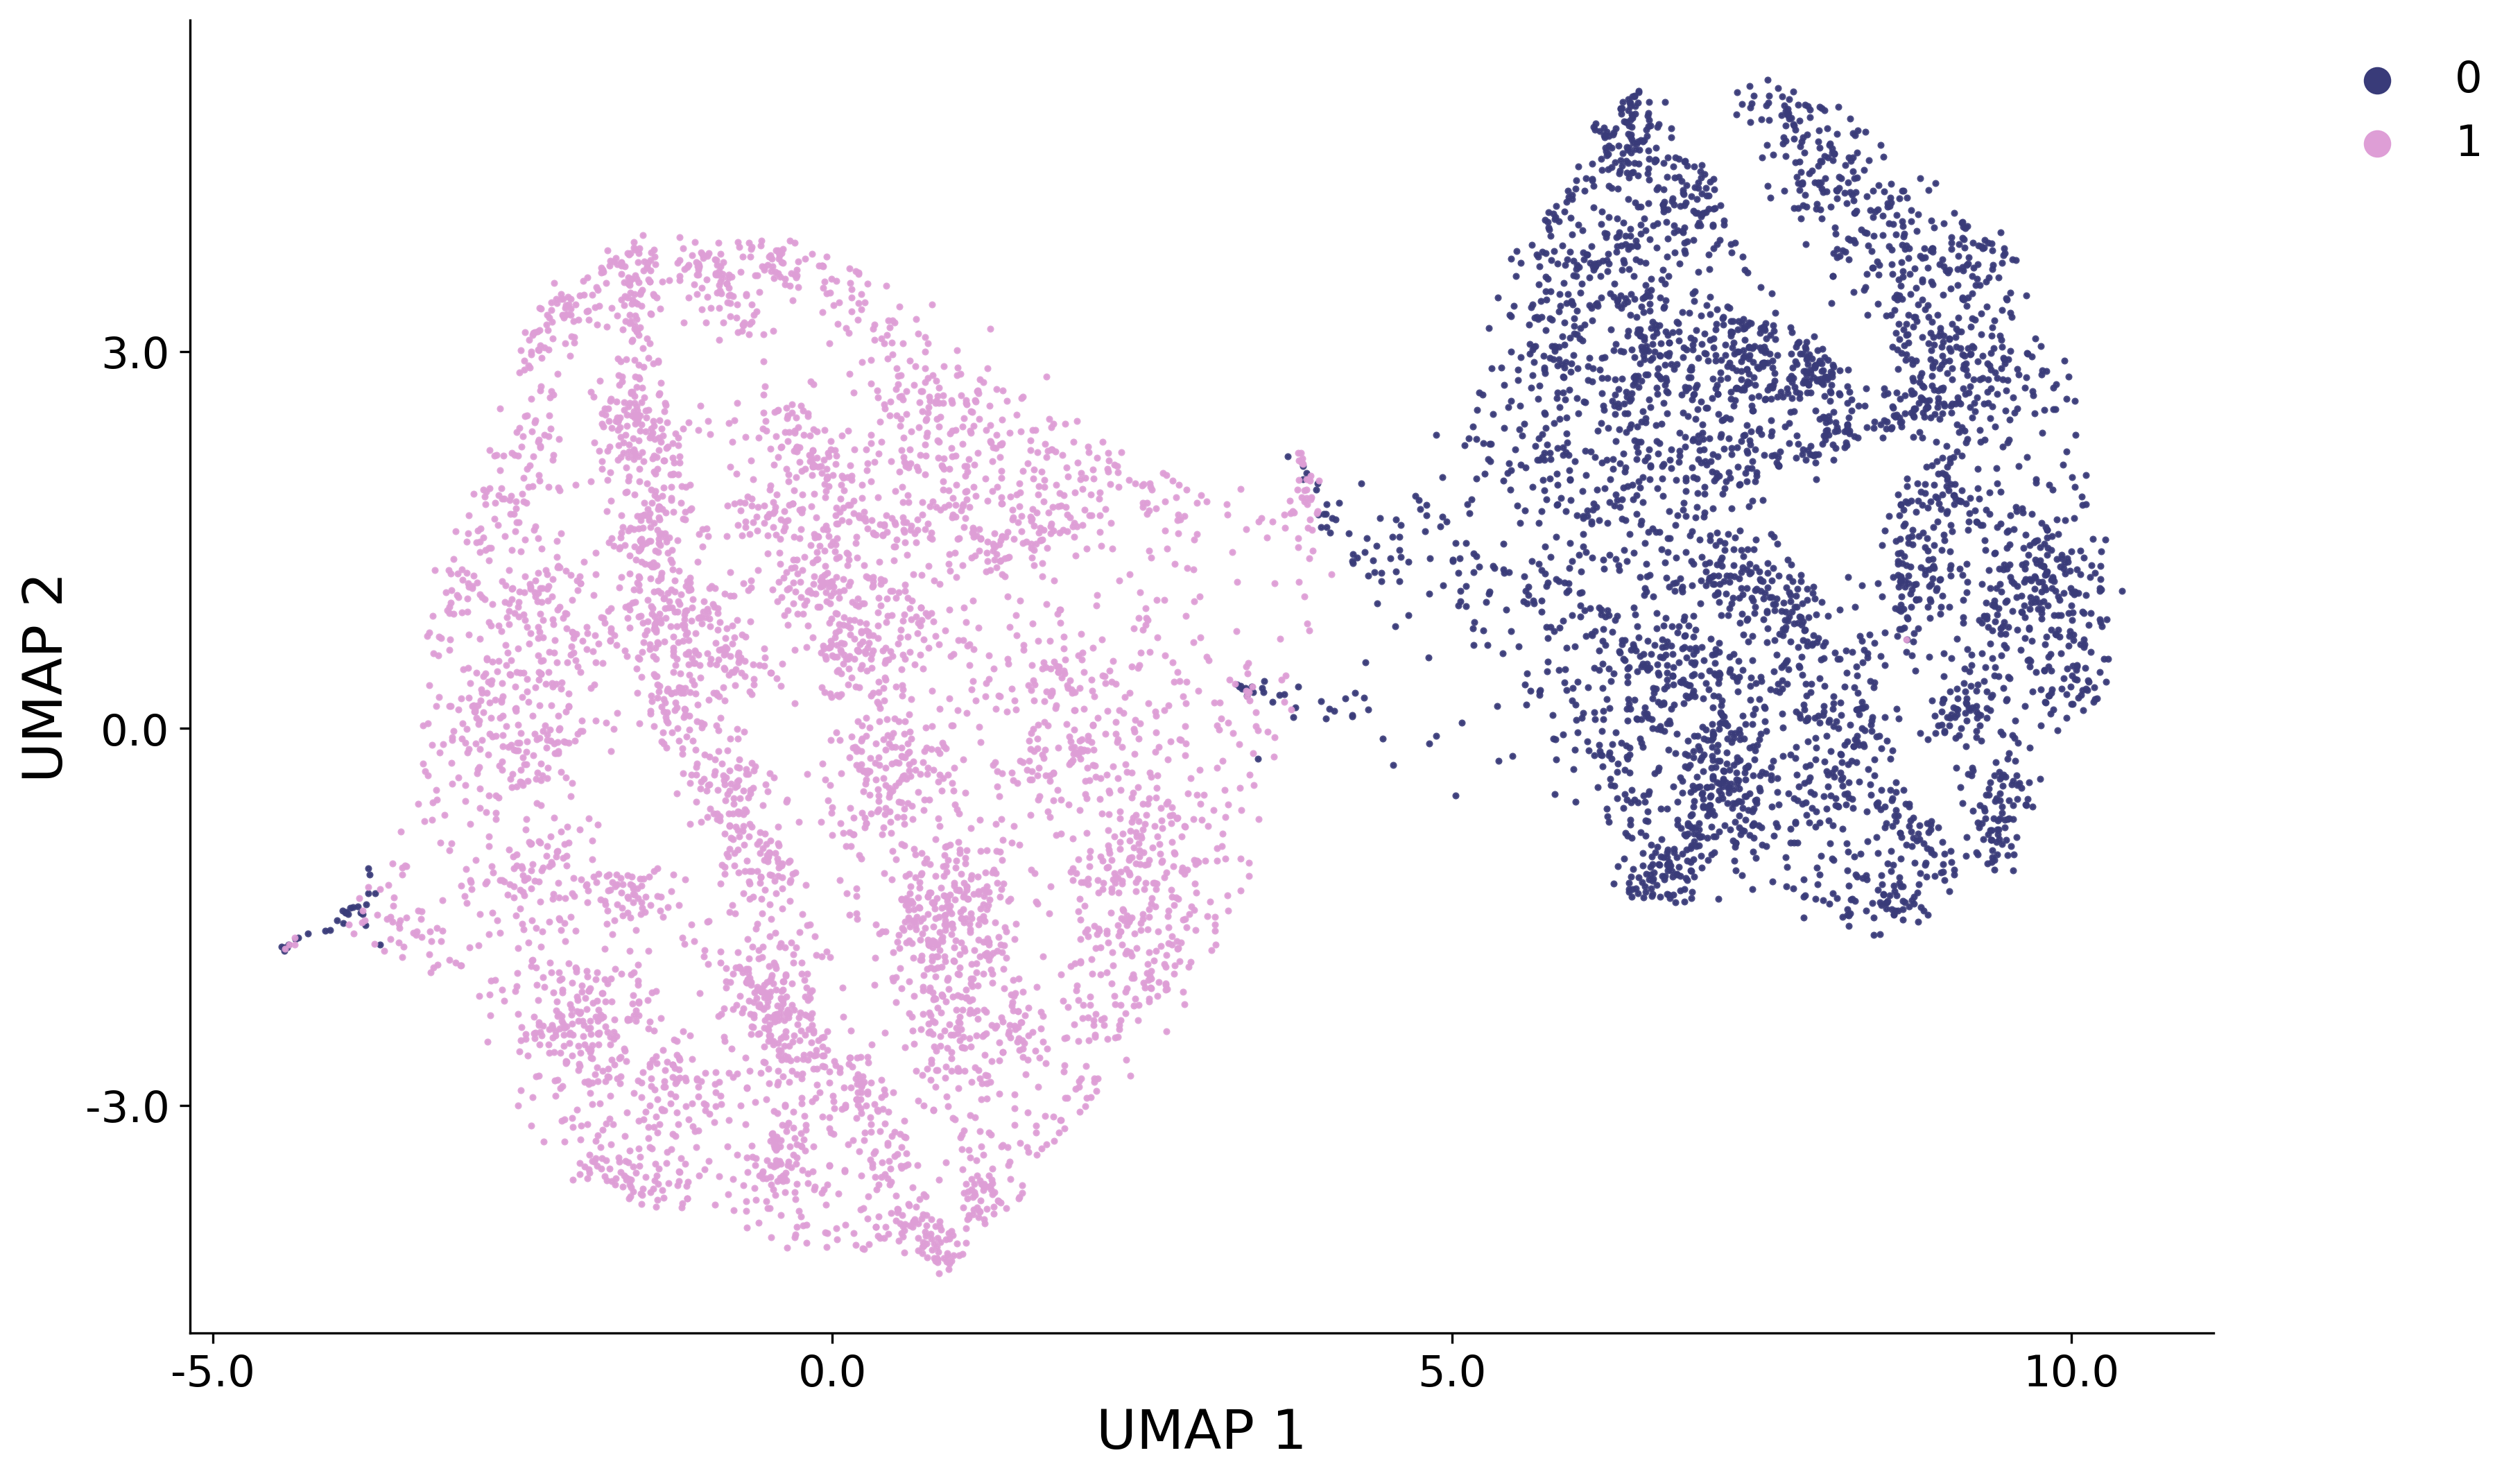

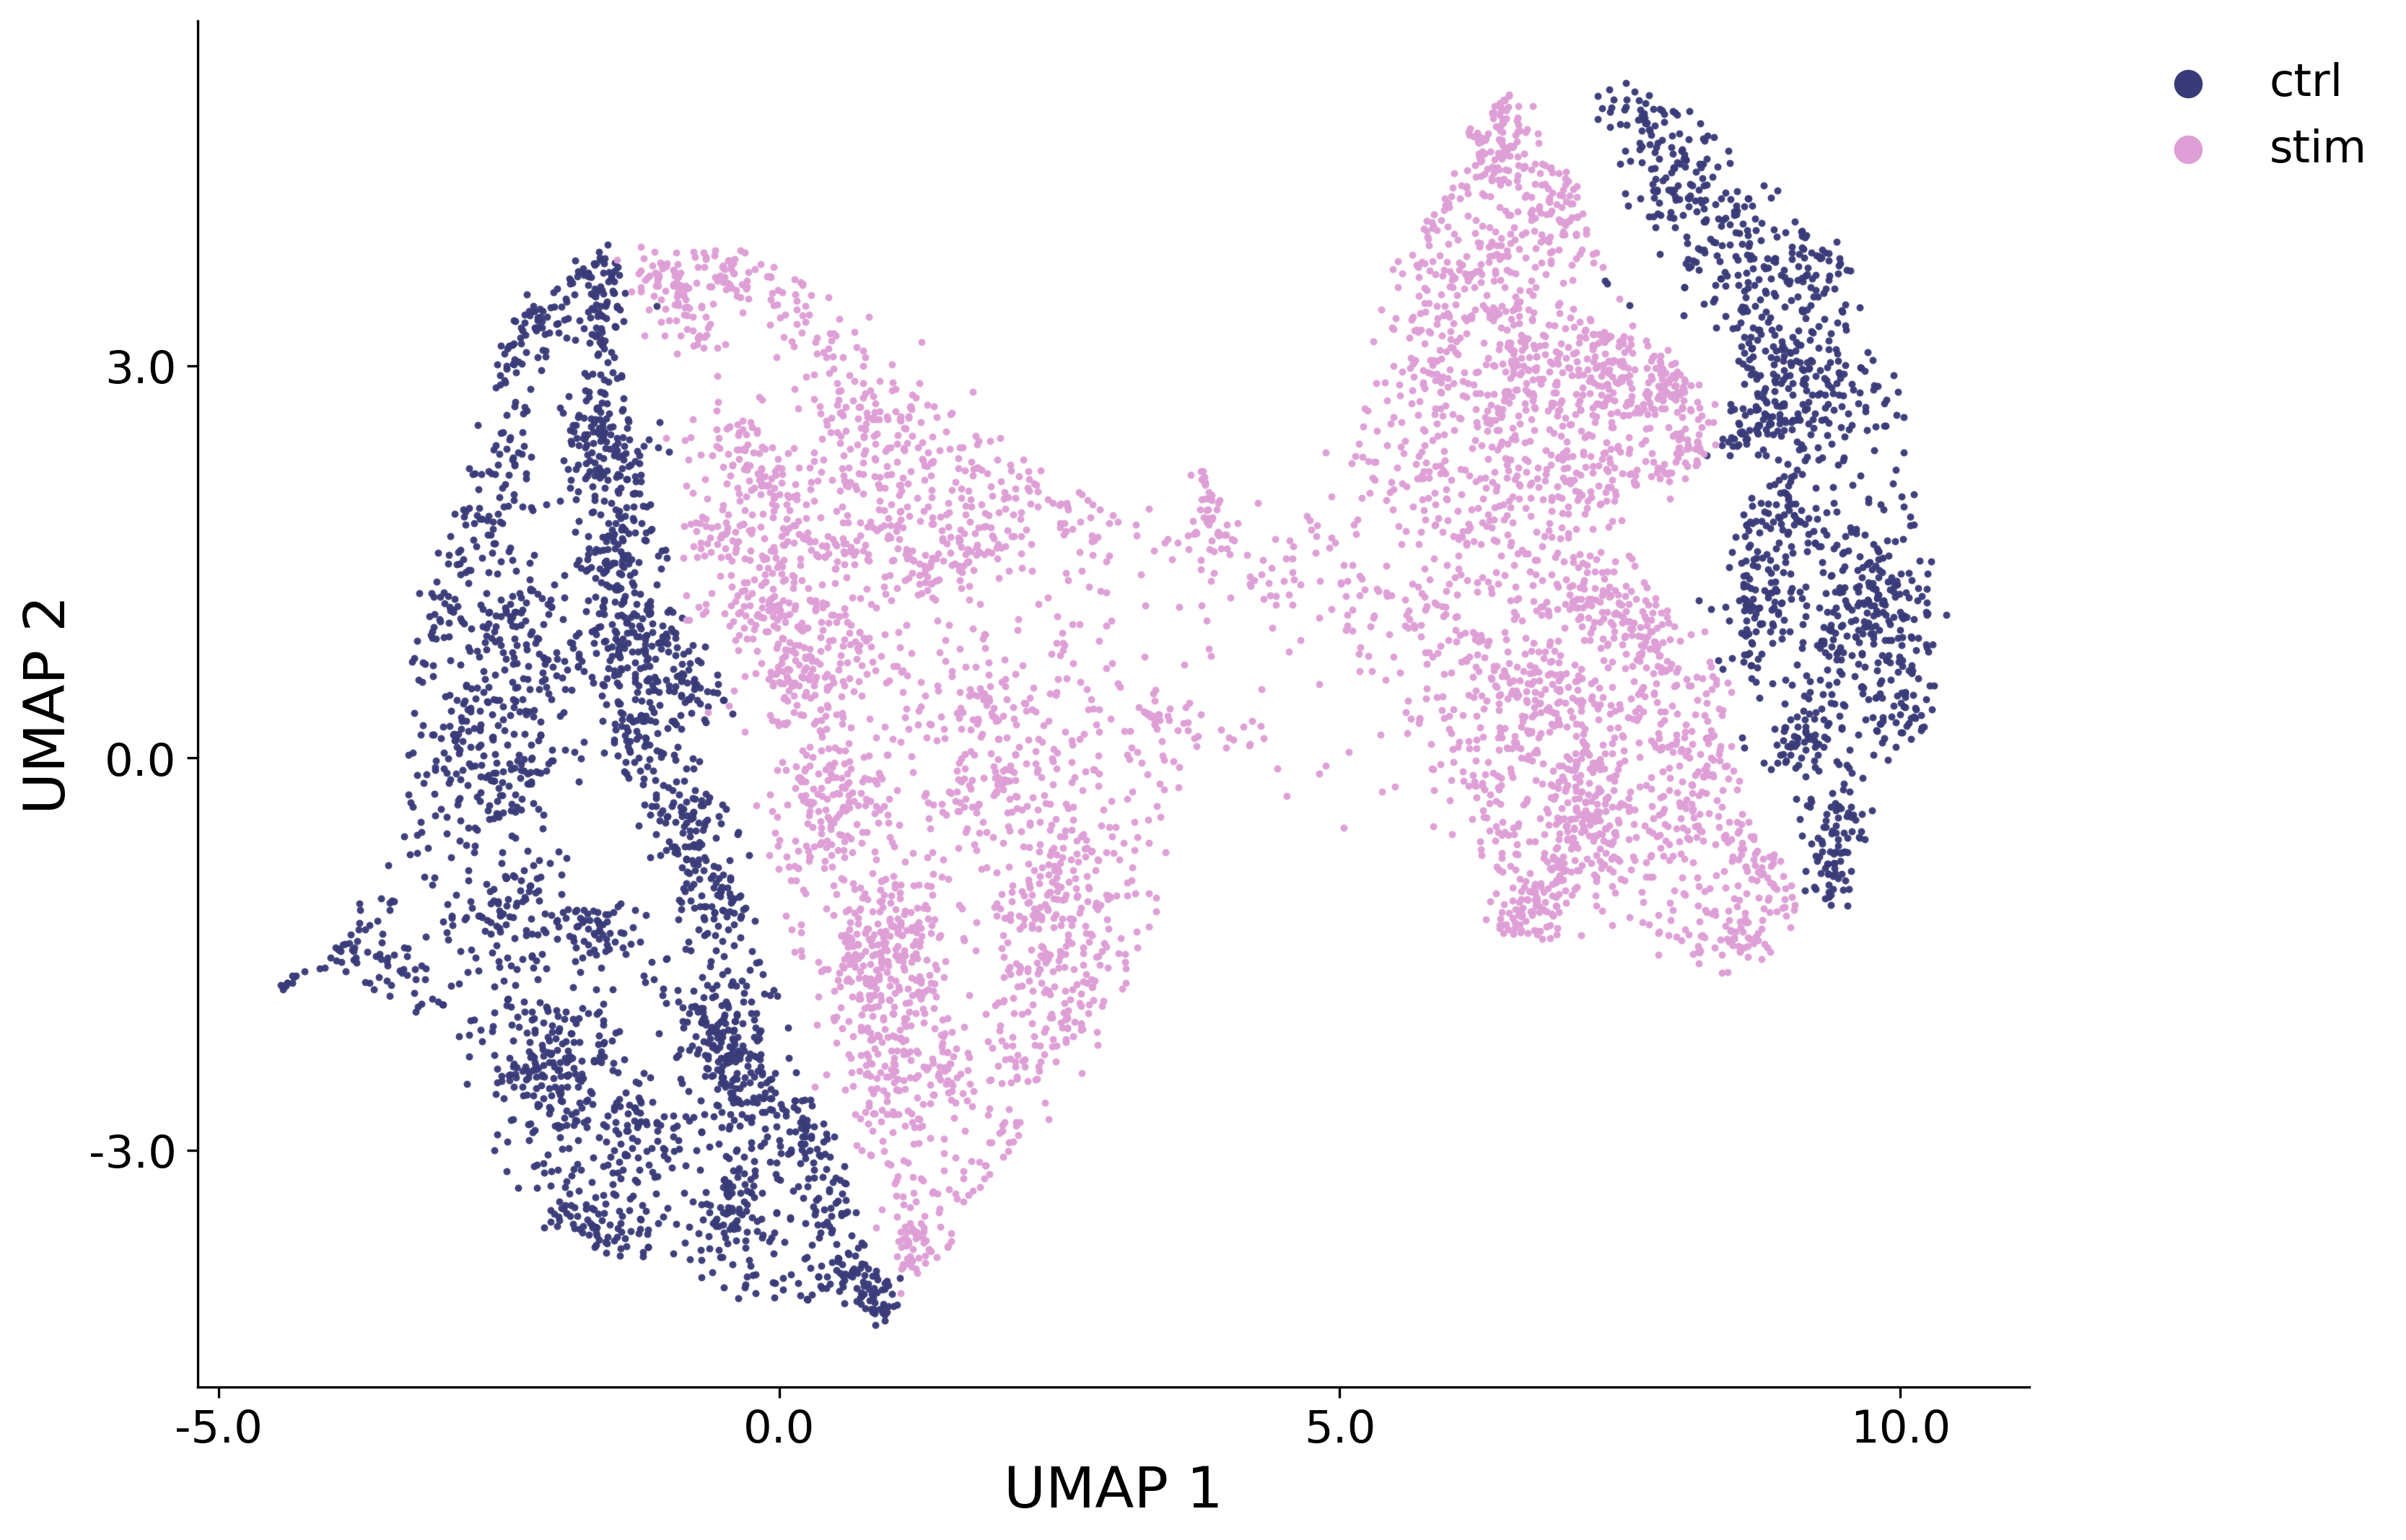

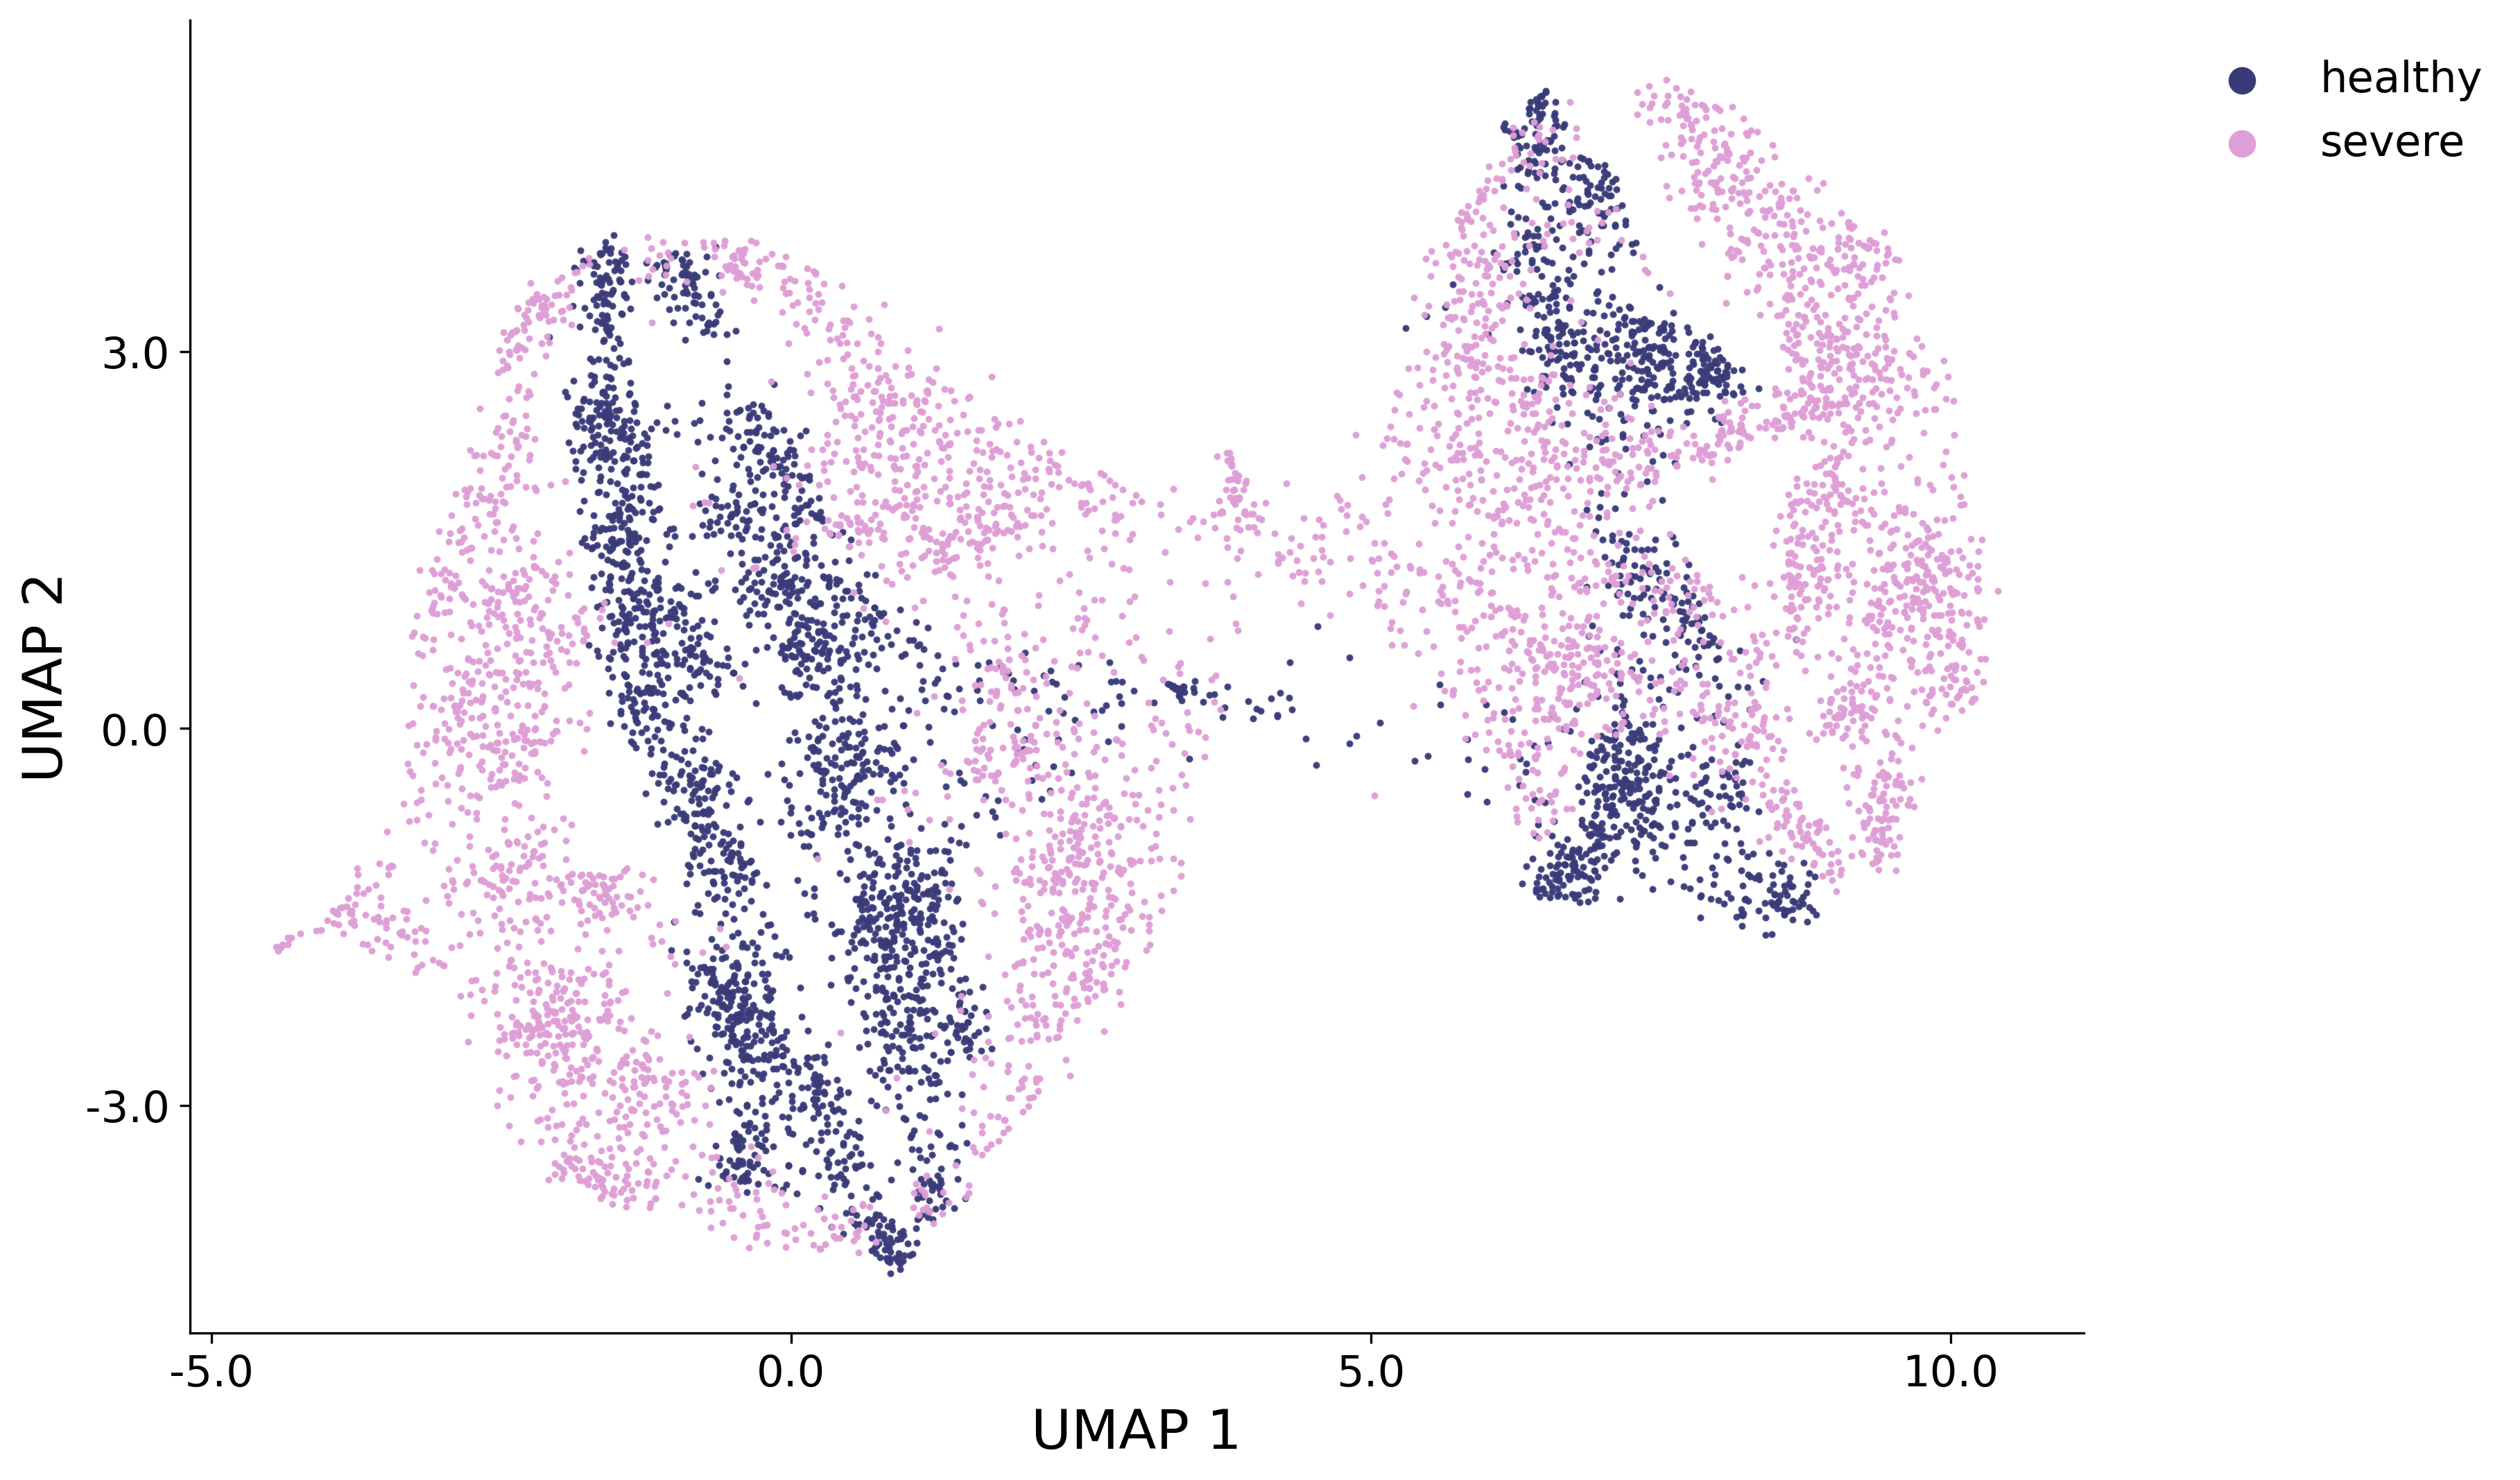

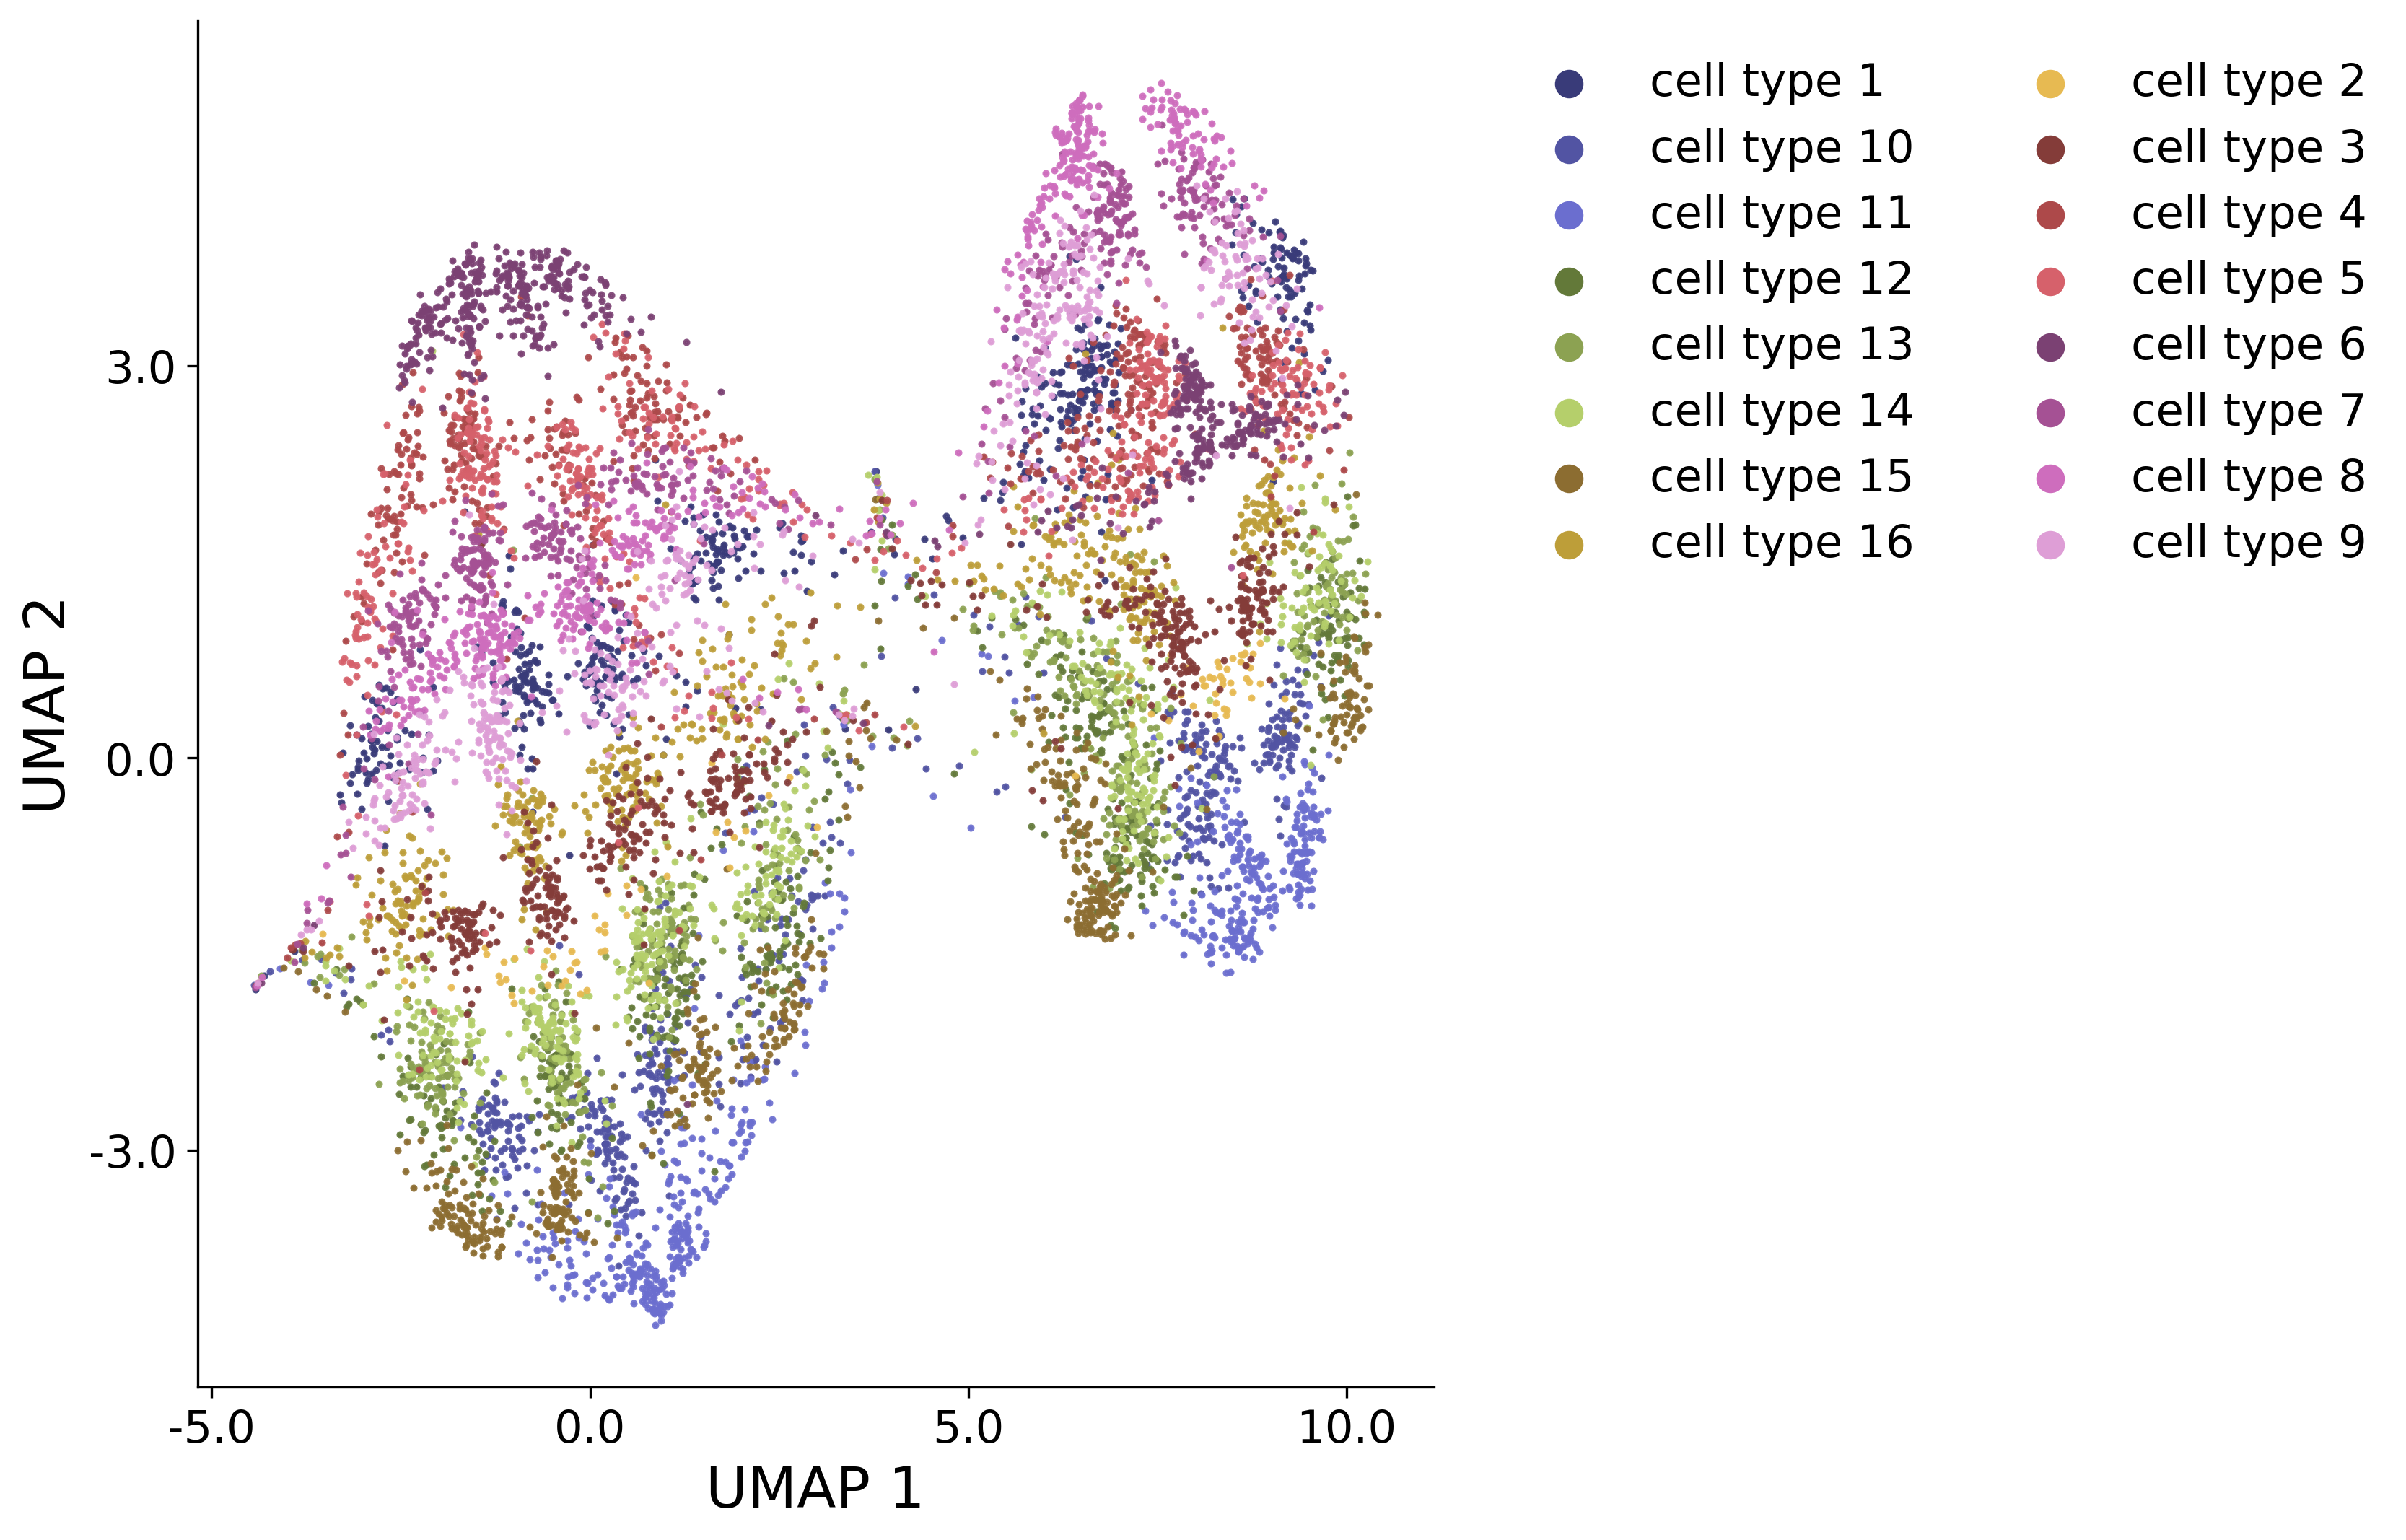

In [3]:
# Visualize the raw gene expression data
umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0) 

x_pca = PCA(n_components = 80).fit_transform(np.concatenate([x.counts_norm for x in data_dict["datasets"]], axis = 0))
x_umap = umap_op.fit_transform(x_pca)

utils.plot_latent(x_umap, annos = np.concatenate([x["batch"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "batches.png", figsize = (12,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umap, annos = np.concatenate([x["condition 1"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "condition_type_1.png", figsize = (11,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umap, annos = np.concatenate([x["condition 2"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "condition_type_2.png", figsize = (12,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "celltypes.png", figsize = (11,7), axis_label = "UMAP", markerscale = 6, s = 2)


## Training scDisInFact
We use the default hyper-parameter setting

In [4]:
# default setting of hyper-parameters
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_gl = 1
reg_tc = 0.5
reg_class = 1
reg_kl = 1e-5
reg_contr = 0.01
# mmd, cross_entropy, total correlation, group_lasso, kl divergence, 
lambs = [reg_mmd_comm, reg_mmd_diff, reg_class, reg_gl, reg_tc, reg_kl, reg_contr]
Ks = [8, 4, 4]

batch_size = 64
nepochs = 100
interval = 10
lr = 5e-4

model = scdisinfact.scdisinfact(data_dict = data_dict, Ks = Ks, batch_size = batch_size, interval = interval, lr = lr, 
                                reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_tc = reg_tc, 
                                reg_kl = reg_kl, reg_class = reg_class, seed = 0, device = device)

model.train()
losses = model.train_model(nepochs = nepochs, recon_loss = "NB", reg_contr = reg_contr)
torch.save(model.state_dict(), result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")
model.load_state_dict(torch.load(result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth", map_location = device))
_ = model.eval()


test dataset shrink to 100
test dataset shrink to 100
test dataset shrink to 100
test dataset shrink to 100
test dataset shrink to 100
test dataset shrink to 100
test dataset shrink to 100
Epoch 0, Validating Loss: 11.4421
	 loss reconstruction: 2.05317
	 loss kl: 10.45008
	 loss mmd common: 2.11053
	 loss mmd diff: 11.54355
	 loss classification: 0.57123
	 loss contrastive: 789.57361
	 loss group lasso diff: 0.55542
	 loss total correlation (disc): 0.73011
GPU memory usage: 13.985352MB
Epoch 10, Validating Loss: 2.9986
	 loss reconstruction: 1.74808
	 loss kl: 146.72018
	 loss mmd common: 5.07006
	 loss mmd diff: 7.92131
	 loss classification: 0.00845
	 loss contrastive: 36.96588
	 loss group lasso diff: 0.51911
	 loss total correlation (disc): 0.70115
GPU memory usage: 13.985352MB
Epoch 20, Validating Loss: 2.6732
	 loss reconstruction: 1.70530
	 loss kl: 125.54981
	 loss mmd common: 2.52450
	 loss mmd diff: 7.67563
	 loss classification: 0.00643
	 loss contrastive: 36.91183
	 loss g

## Visualize shared-bio and unshared-bio factors
After training the model, we extracted the shared-bio and unshared-bio factors from the encoder output.

To conduct forward pass on a test dataset, two functions are needed:
* `model.inference()`: infer the latent factor from the gene expression data (encoder)
* `model.generate()`: generate the gene expression data from the latent factors (decoder)

In [5]:
# one forward pass
z_cs = []
z_ds = []
zs = []

for dataset in data_dict["datasets"]:
    with torch.no_grad():
        # pass through the encoders
        dict_inf = model.inference(counts = dataset.counts_norm.to(model.device), batch_ids = dataset.batch_id[:,None].to(model.device), print_stat = True)
        # pass through the decoder
        dict_gen = model.generative(z_c = dict_inf["mu_c"], z_d = dict_inf["mu_d"], batch_ids = dataset.batch_id[:,None].to(model.device))
        z_c = dict_inf["mu_c"]
        z_d = dict_inf["mu_d"]
        z = torch.cat([z_c] + z_d, dim = 1)
        mu = dict_gen["mu"]    
        z_ds.append([x.cpu().detach().numpy() for x in z_d])
        z_cs.append(z_c.cpu().detach().numpy())
        zs.append(np.concatenate([z_cs[-1]] + z_ds[-1], axis = 1))



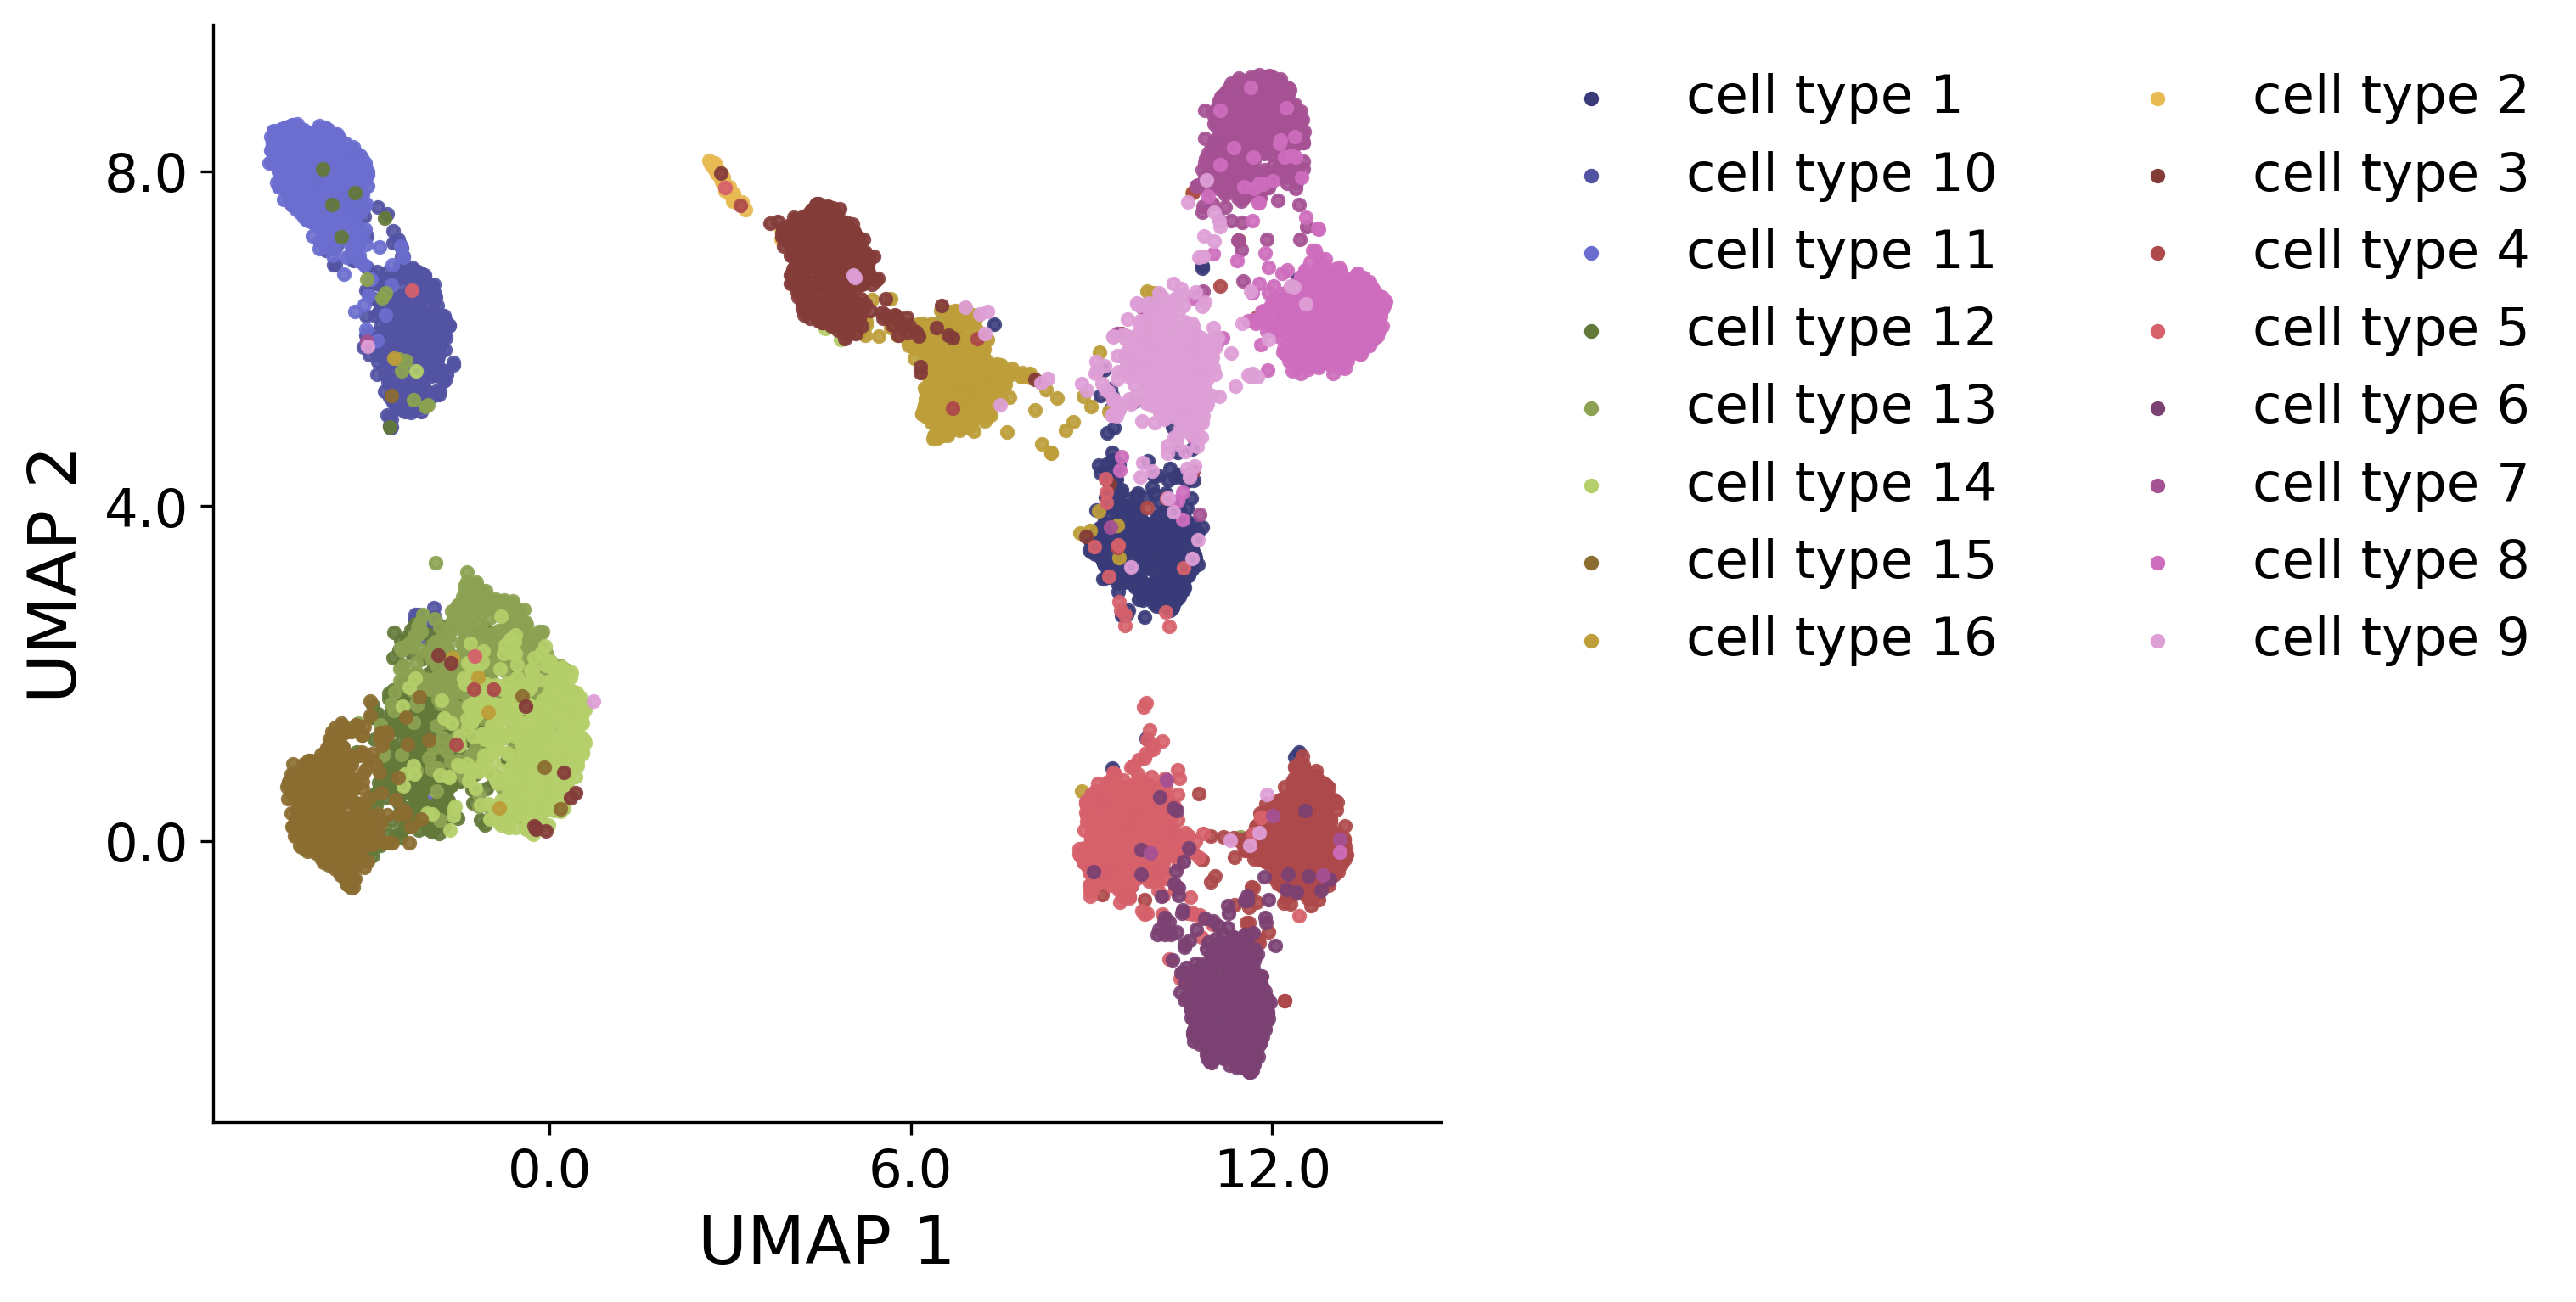

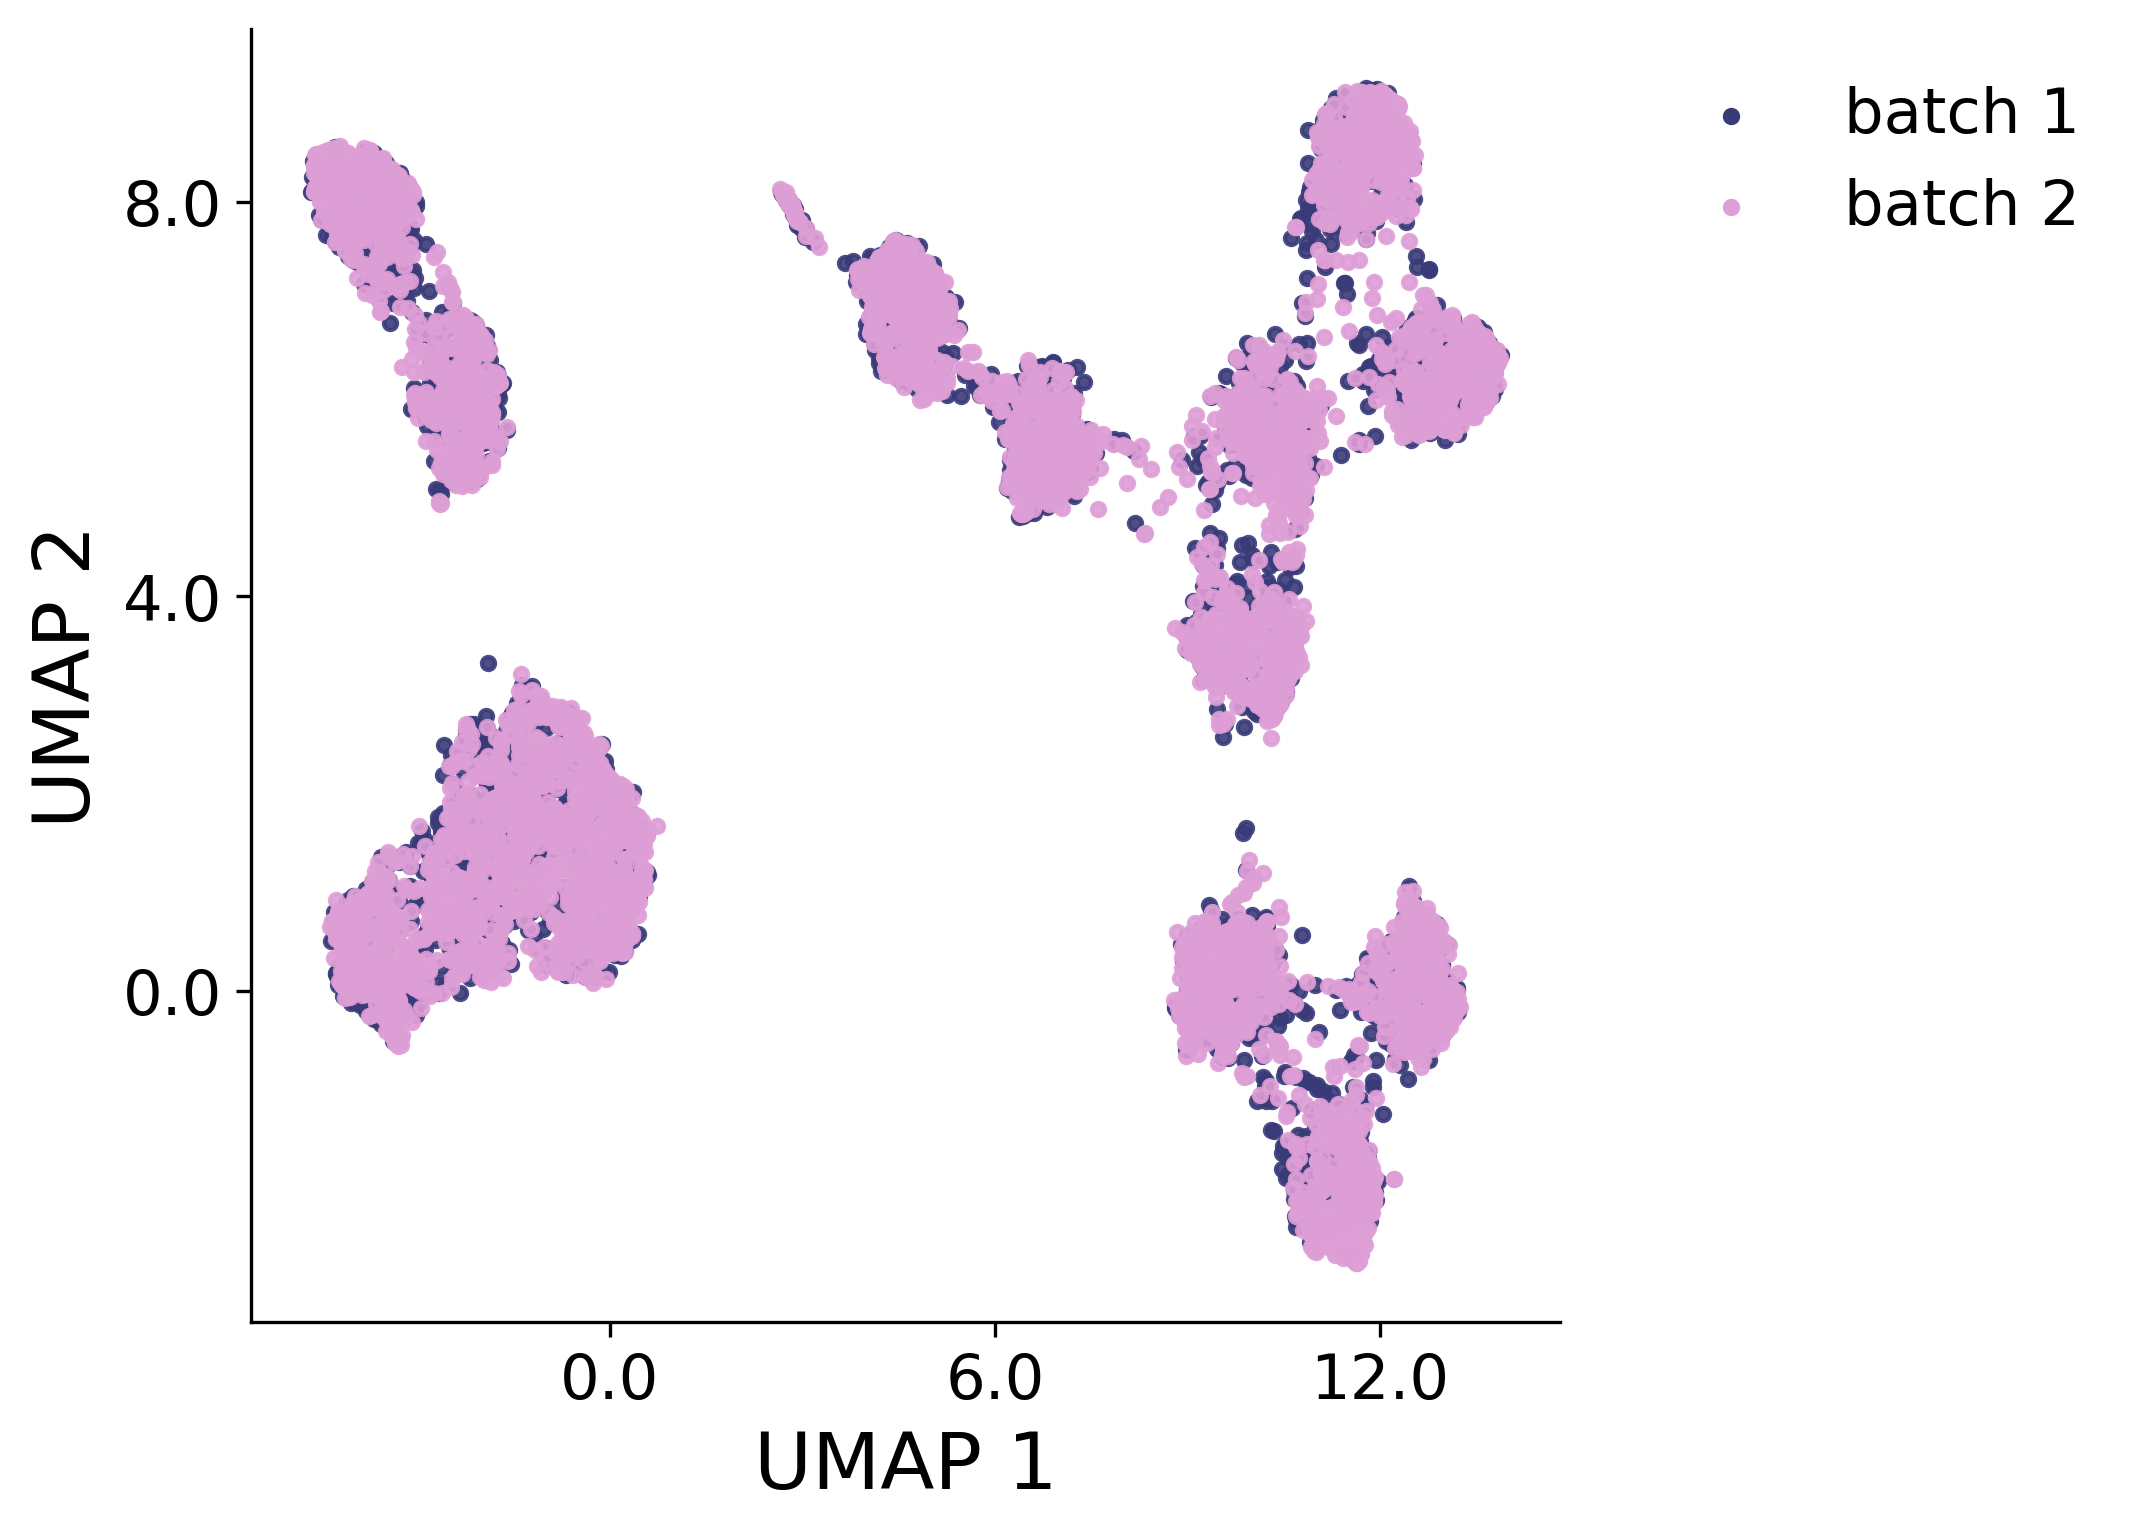

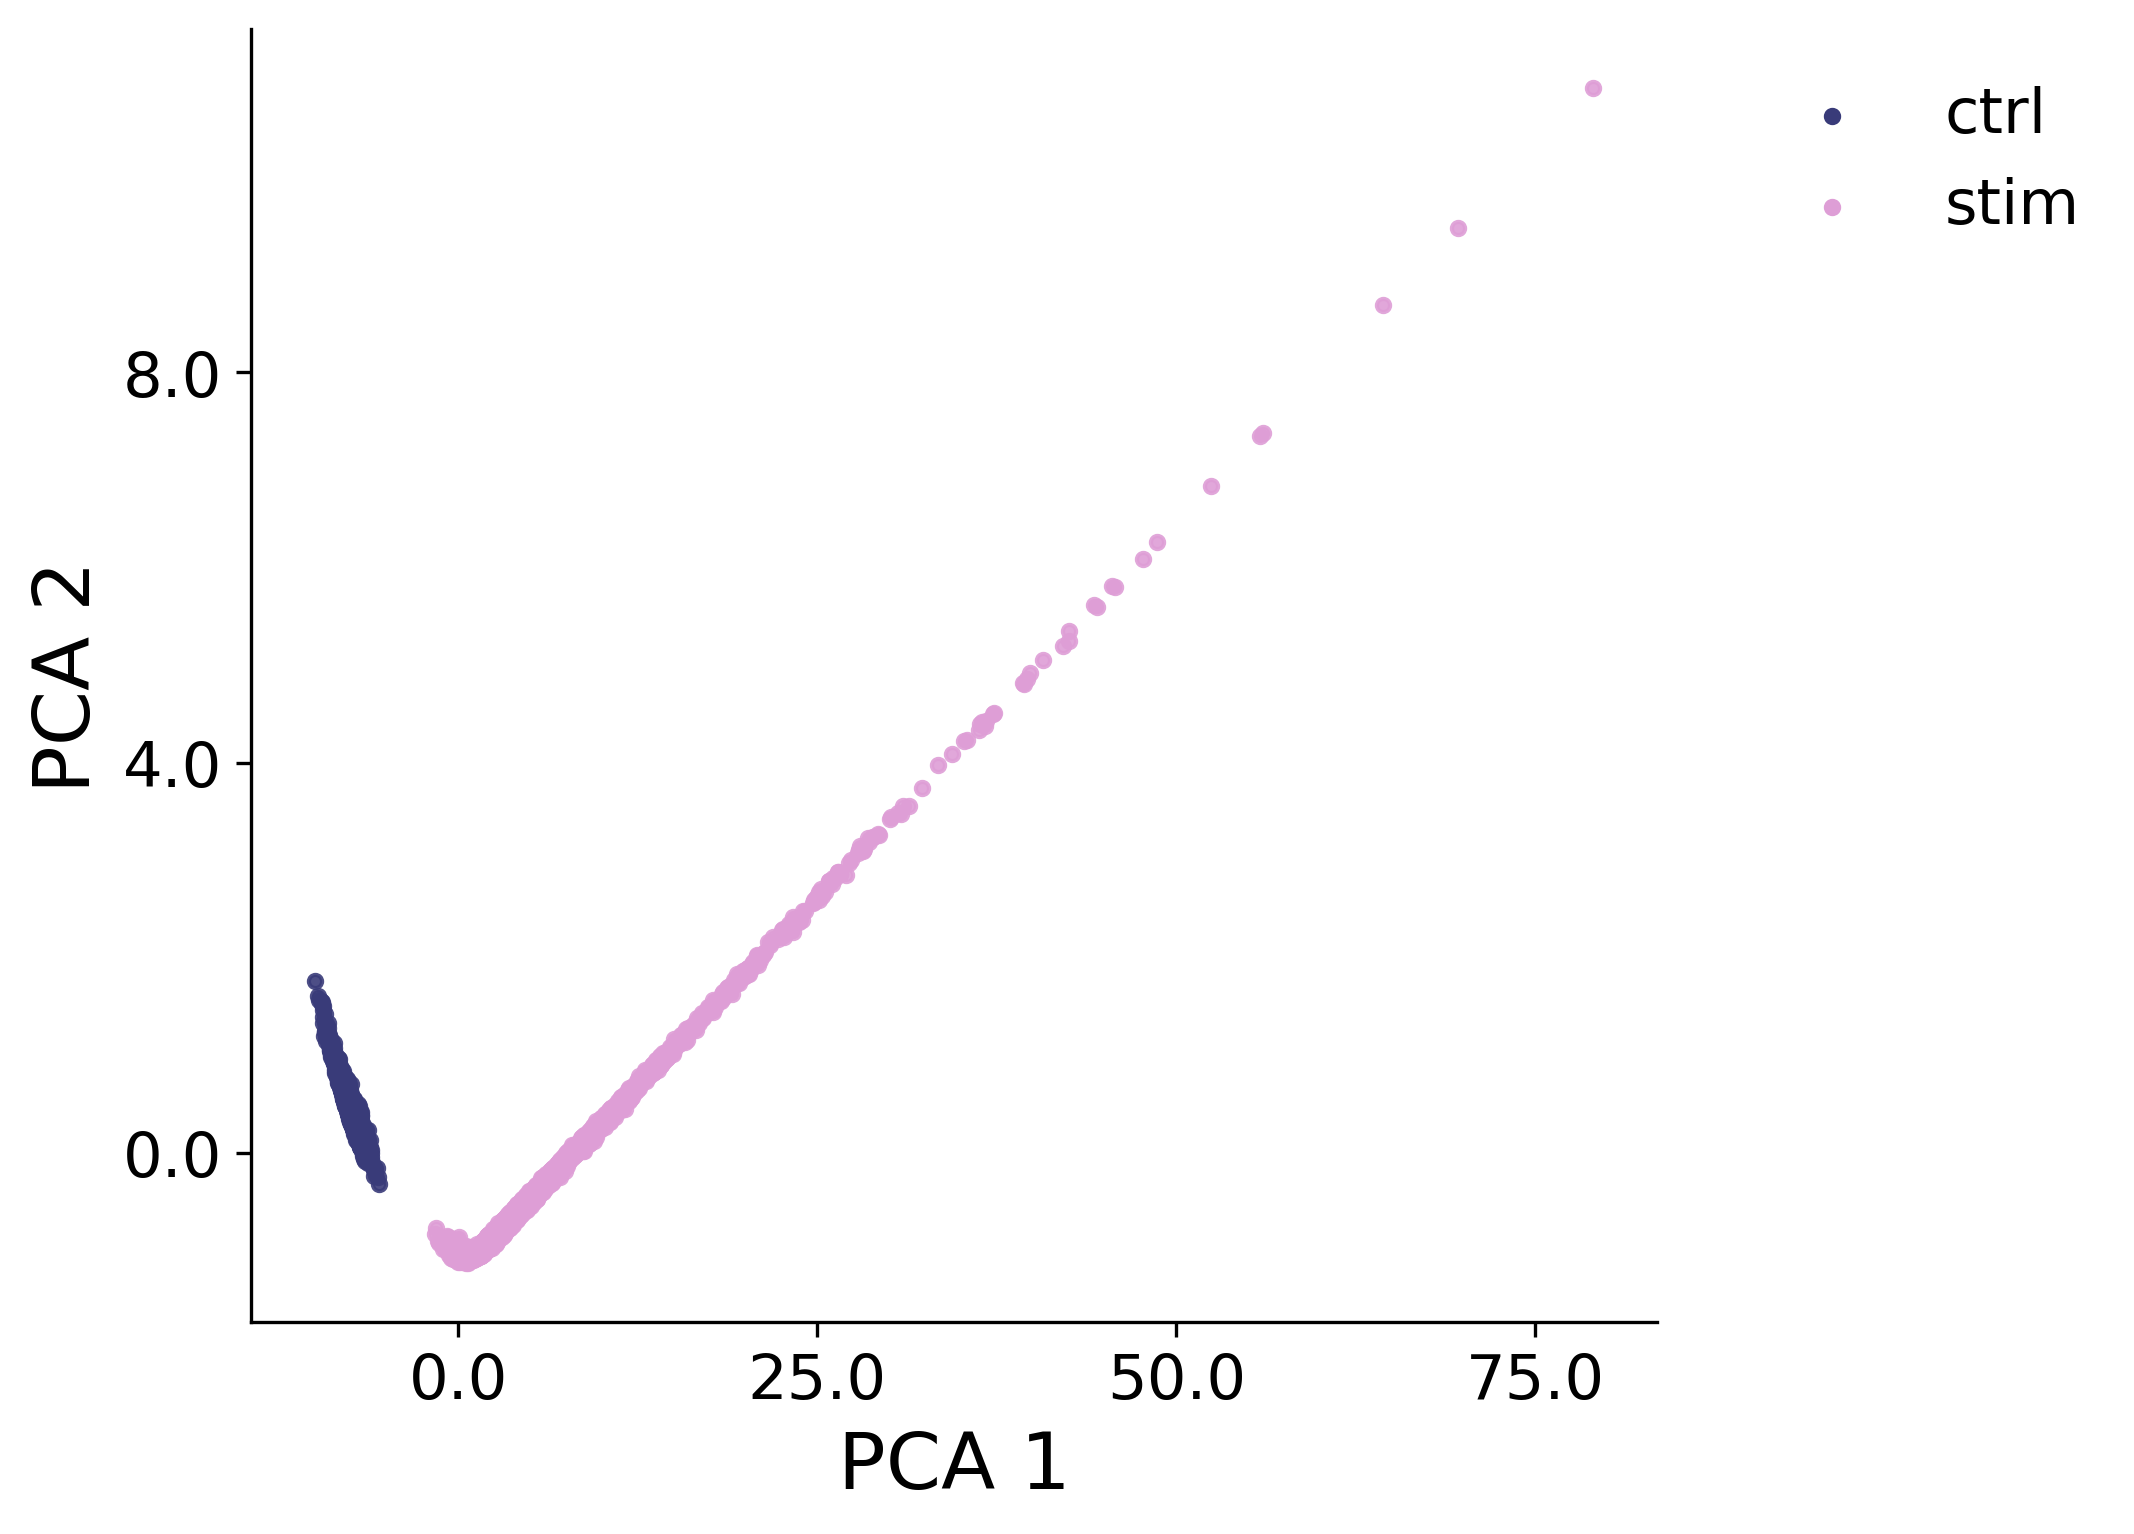

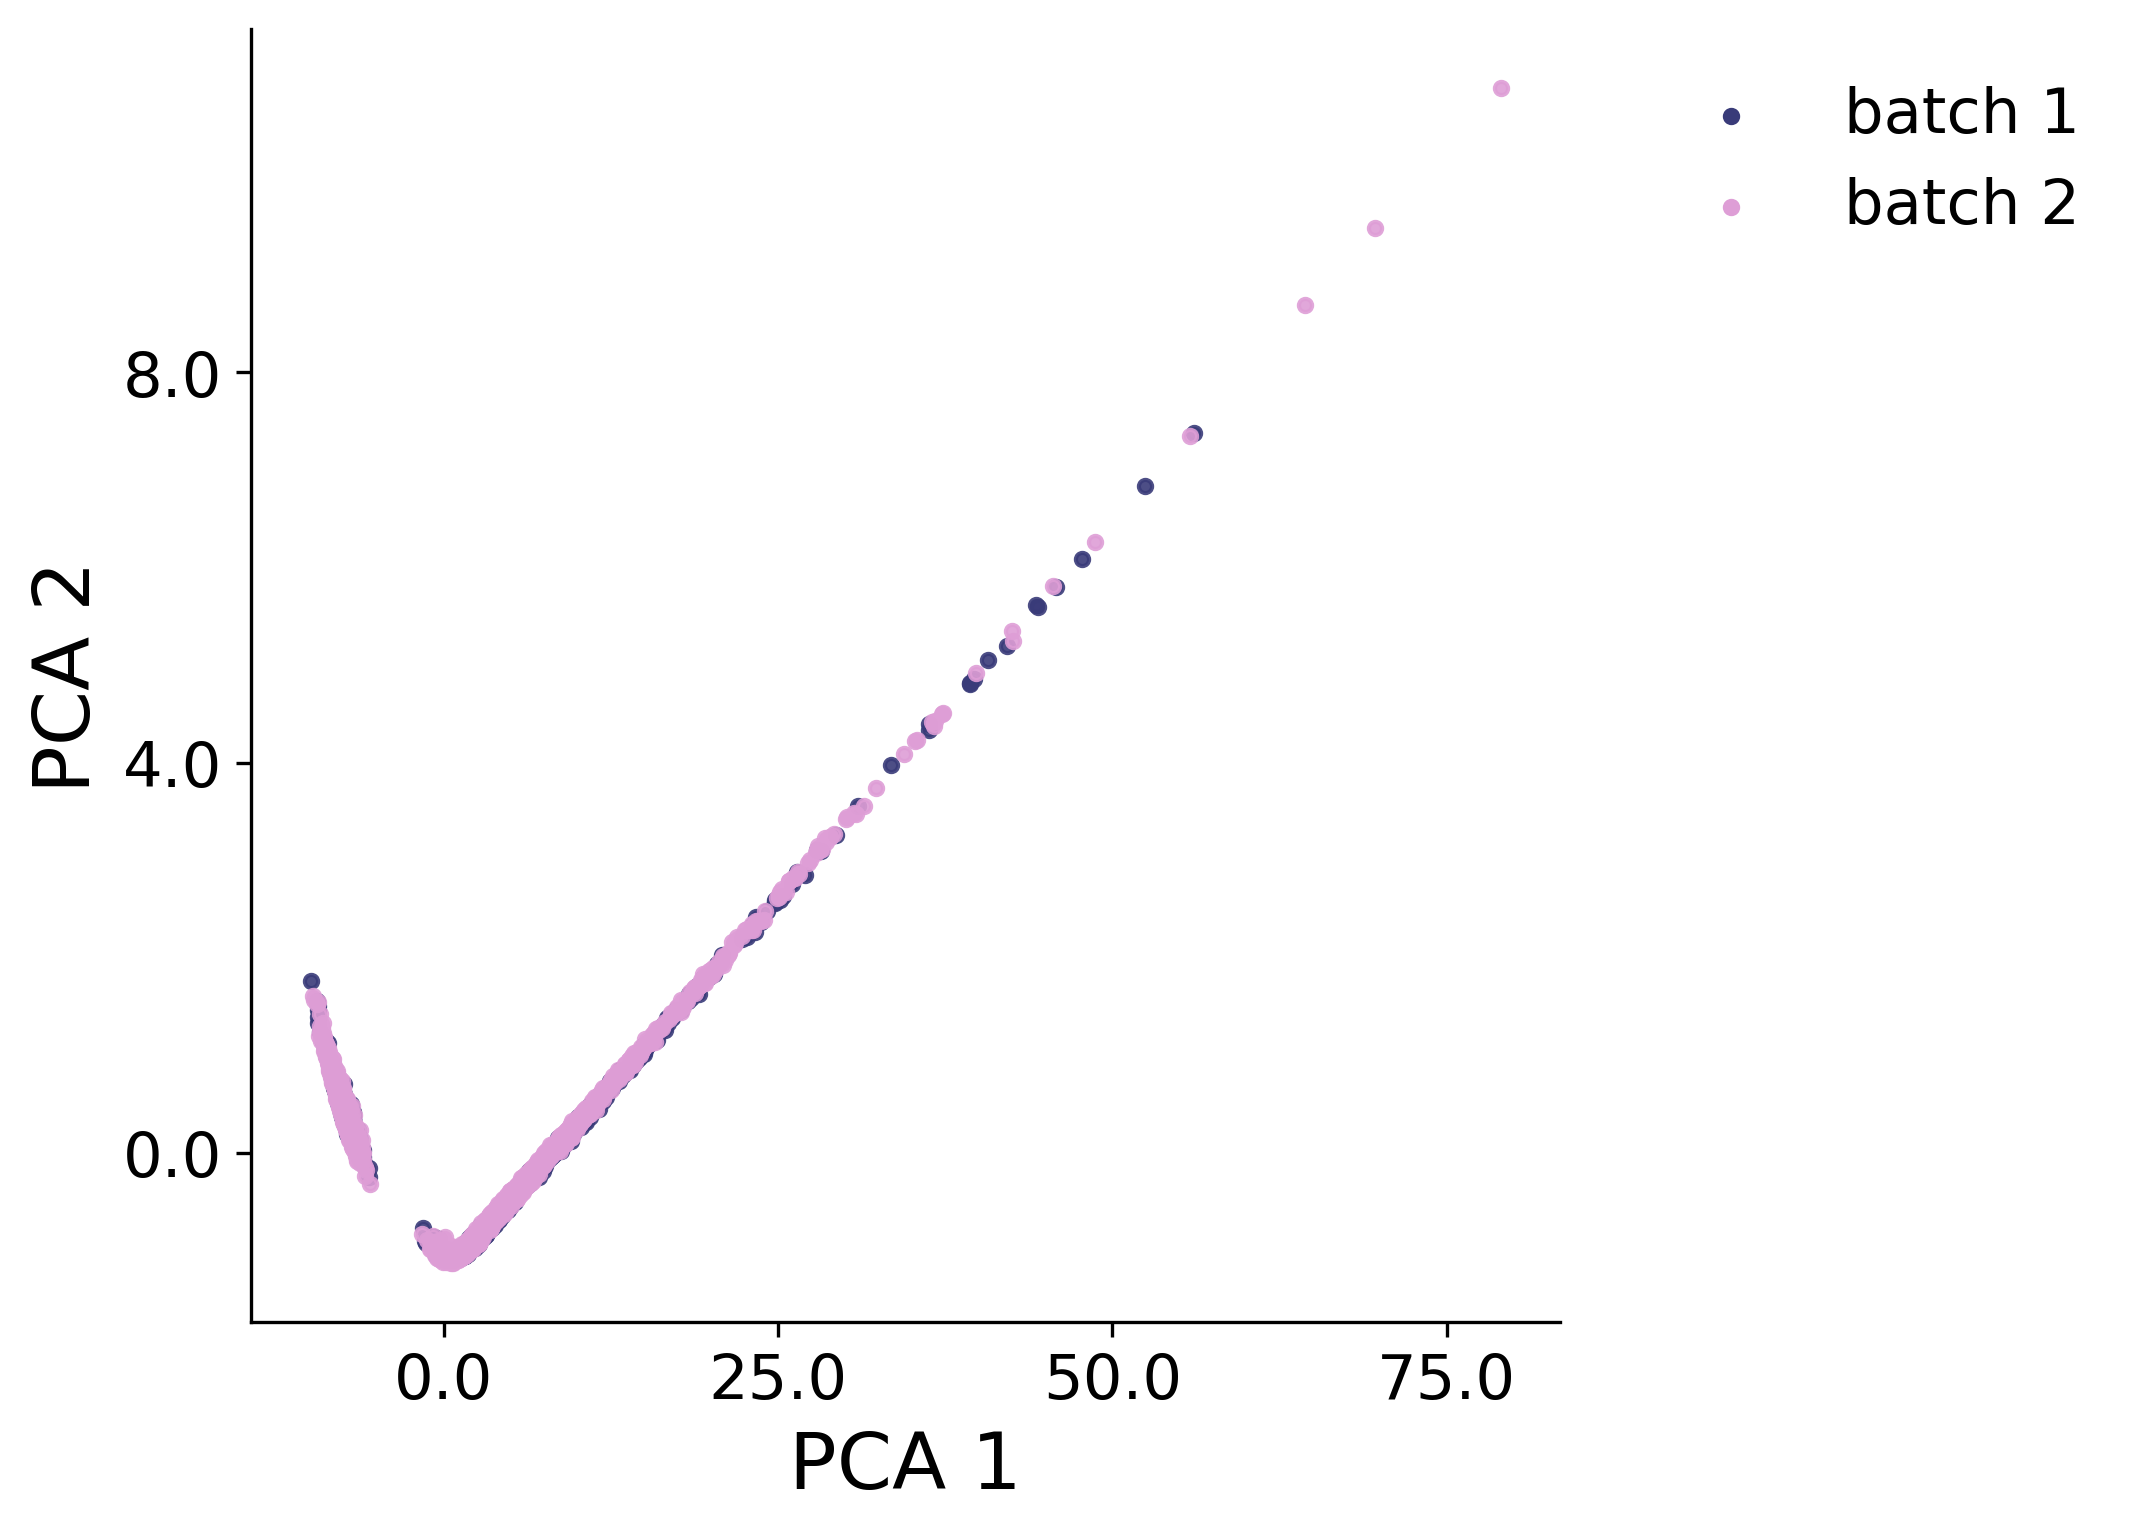

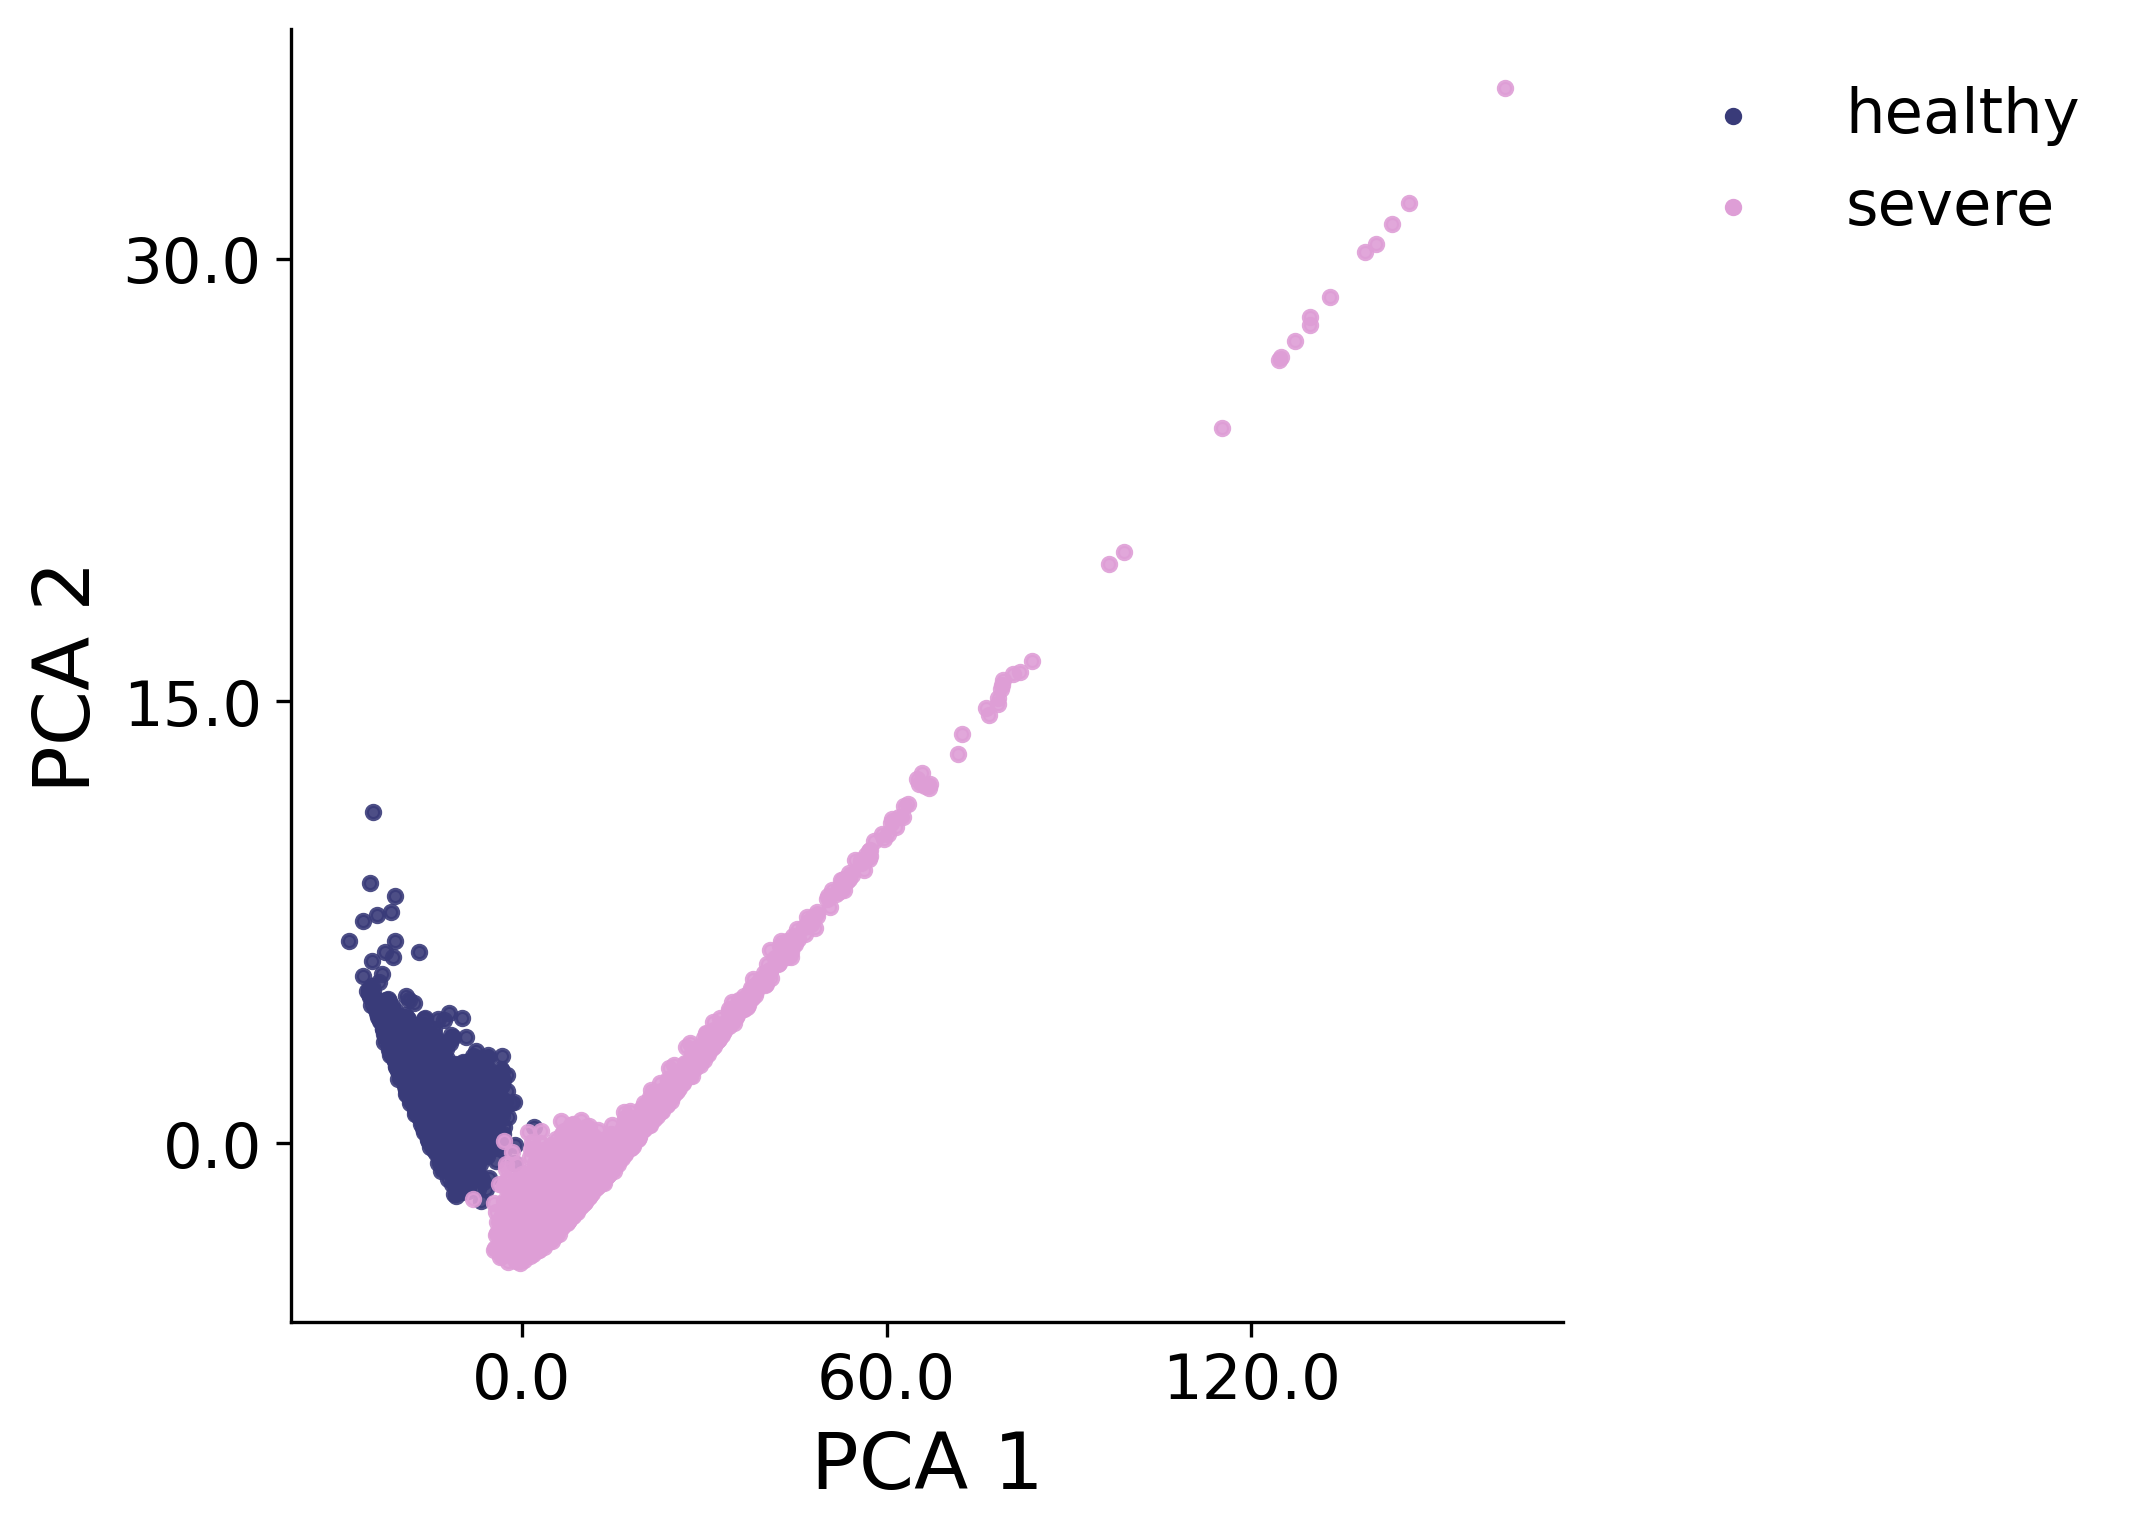

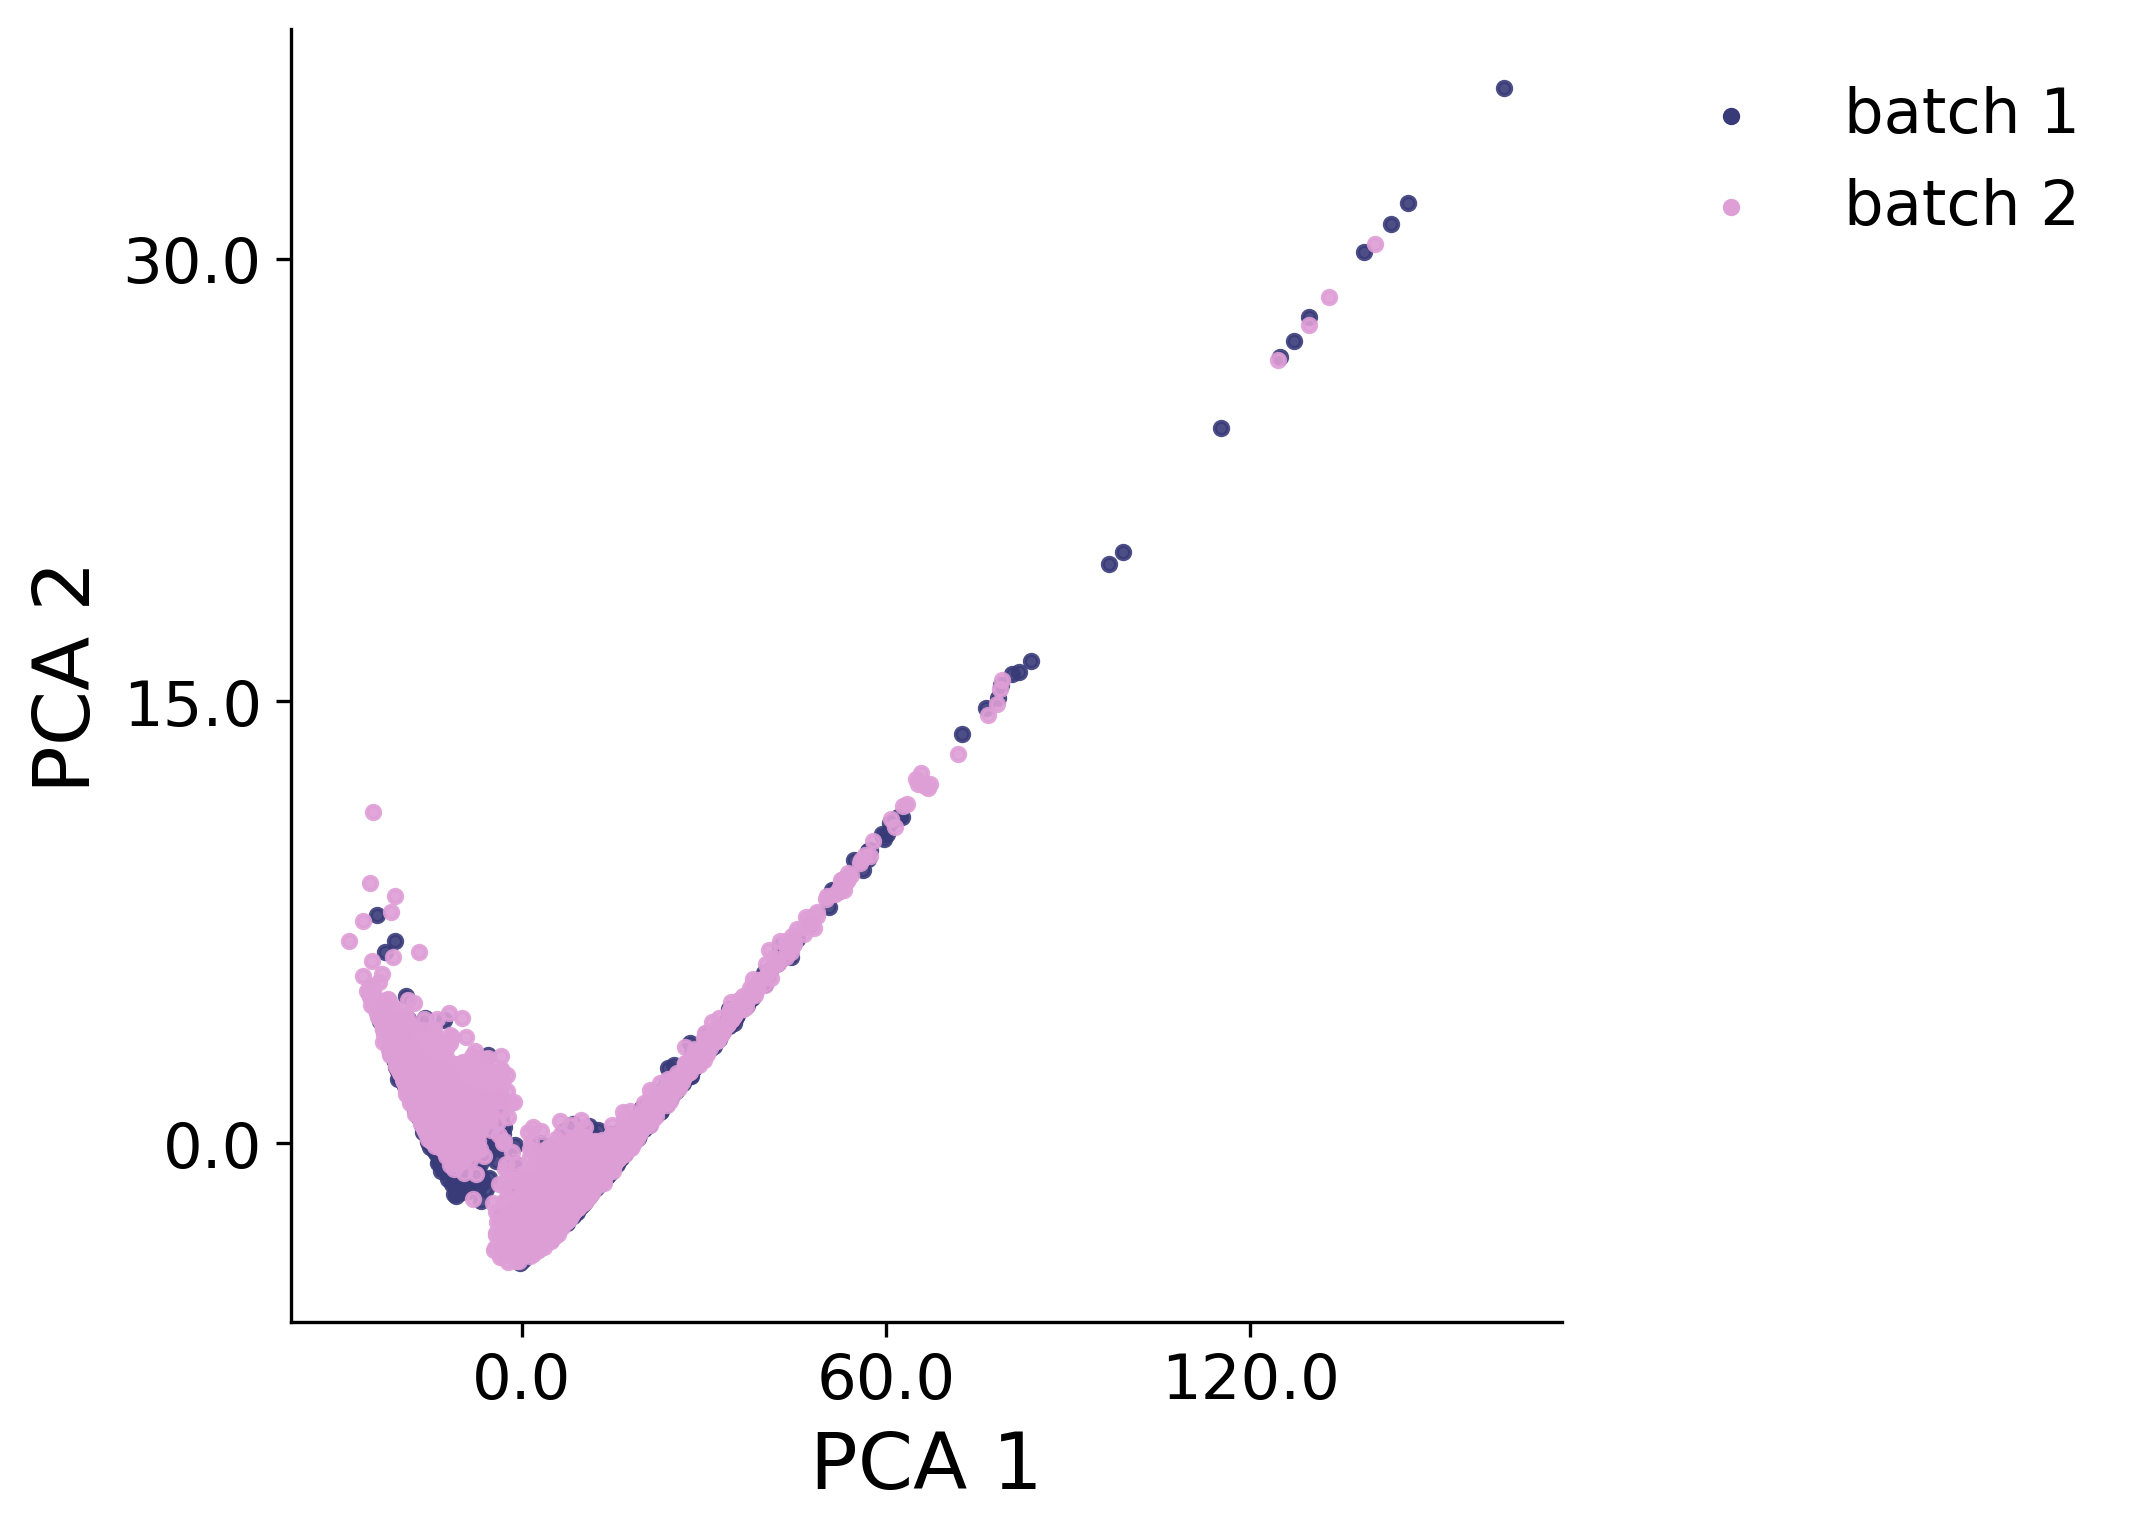

In [6]:
# UMAP
umap_op = UMAP(min_dist = 0.1, random_state = 0)
pca_op = PCA(n_components = 2)
z_cs_umap = umap_op.fit_transform(np.concatenate(z_cs, axis = 0))
z_ds_umap = []
z_ds_umap.append(pca_op.fit_transform(np.concatenate([z_d[0] for z_d in z_ds], axis = 0)))
z_ds_umap.append(pca_op.fit_transform(np.concatenate([z_d[1] for z_d in z_ds], axis = 0)))

comment = f'results_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}/'
if not os.path.exists(result_dir + comment):
    os.makedirs(result_dir + comment)

batch_annos = np.concatenate([x["batch"].values.squeeze() for x in data_dict["meta_cells"]])
batch_annos = np.where(batch_annos == 0, "batch 1", "batch 2")
utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "UMAP", figsize = (10,5), save = result_dir + comment+"common_dims_annos.png")
# utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "separate", axis_label = "UMAP", figsize = (10,10), save = result_dir + comment+"common_dims_annos_separate.png")

utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "batches", axis_label = "UMAP", figsize = (7,5), save = result_dir + comment+"common_dims_batches.png")
# utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["condition 1"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "UMAP", figsize = (7,5), save = result_dir + comment+"common_dims_cond1.png")

utils.plot_latent(zs = z_ds_umap[0], annos = np.concatenate([x["condition 1"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims1_cond1.png")
utils.plot_latent(zs = z_ds_umap[0], annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "batches", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims1_batches.png")

utils.plot_latent(zs = z_ds_umap[1], annos = np.concatenate([x["condition 2"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims2_cond1.png")
utils.plot_latent(zs = z_ds_umap[1], annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "batches", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims2_batches.png")


## Key gene extraction

The condition-associated gene scores can be extracted with `model.extract_gene_scores()`. The function returns a list with length equal to the total number of condition types. The $i$th element is the scores of genes (a `np.array`) under that condition type, the order of the scores matches the input genes. 

In [11]:
gene_scores = model.extract_gene_scores()
# the scores of 500 genes for condition type 1
print(gene_scores[0])
# the scores of 500 genes for condition type 2
print(gene_scores[1])


[9.46509000e-03 5.97796170e-03 6.08936138e-03 9.18788742e-03
 6.88126637e-03 4.54049520e-02 1.19550396e-02 2.84555200e-02
 1.12875402e-02 1.41337132e-02 1.03132240e-02 1.04943151e-02
 8.31638649e-03 6.06745481e-03 6.17572758e-03 1.16961412e-02
 1.37044992e-02 1.74097735e-02 5.06660761e-03 1.85824130e-02
 5.82705485e-03 6.16846839e-03 2.17081178e-02 2.00244784e-02
 5.33023849e-03 8.07552226e-03 6.49201451e-03 6.94970740e-03
 9.88544617e-03 6.82920916e-03 9.60503332e-03 2.84975599e-02
 1.33449631e-02 5.75001631e-03 6.26575015e-03 5.91141451e-03
 5.07775275e-03 9.01667122e-03 4.49178508e-03 1.42140621e-02
 9.33120679e-03 7.95881357e-03 5.63171878e-03 1.22293690e-02
 5.92500484e-03 8.87458492e-03 1.97683964e-02 7.57483300e-03
 1.33972736e-02 9.97905433e-03 2.15870544e-01 3.84325355e-01
 2.81139046e-01 1.74817443e-01 5.15316874e-02 2.31318265e-01
 4.54833768e-02 1.13113441e-01 4.42099087e-02 3.62187654e-01
 1.95054680e-01 4.67284024e-01 2.81055301e-01 4.35932614e-02
 3.89717370e-01 2.861812

## Prediction
Predict the count of the data under a different condition (and even remove the batch effect) with `model.predic_counts`. 
* `predict_dataset` takes as input a scDisInFact dataset that user wish to perform prediction on. 
* `predict_conds` take as input a list of predicting condition groups under each condition type.
* `predict_batch` take as input a value of the batch that the predicted count should be matched to.



Given the test matrix under `(stim, severe, batch 1)`, and we wish to predict the corresponding count matrix under `(ctrl, healthy, batch 0)`. We need to run

In [12]:
input_idx = ((meta_cells["condition 1"] == "stim") & (meta_cells["condition 2"] == "severe") & (meta_cells["batch"] == 1)).values
counts_input = counts[input_idx,:].toarray()
meta_input = meta_cells.loc[input_idx,:]

counts_predict = model.predict_counts(input_counts = counts_input, meta_cells = meta_input, condition_keys = ["condition 1", "condition 2"], 
                                      batch_key = "batch", predict_conds = ["ctrl", "healthy"], predict_batch = 0)


We can also denoise the count matrix under `(ctrl, healthy, batch 0)` by setting the `predict_conds` and `predict_batch` to be `None`

In [13]:
test_idx = ((meta_cells["condition 1"] == "ctrl") & (meta_cells["condition 2"] == "healthy") & (meta_cells["batch"] == 0)).values
counts_test = counts[test_idx,:].toarray()
meta_test = meta_cells.loc[test_idx,:]

counts_test_denoised = model.predict_counts(input_counts = counts_test, meta_cells = meta_test, condition_keys = ["condition 1", "condition 2"], 
                                            batch_key = "batch", predict_conds = None, predict_batch = None)

Visualize the predicted counts and the denoised test count. Since condition and batch are aligned between predicted and test count, the gene expression should be also aligned

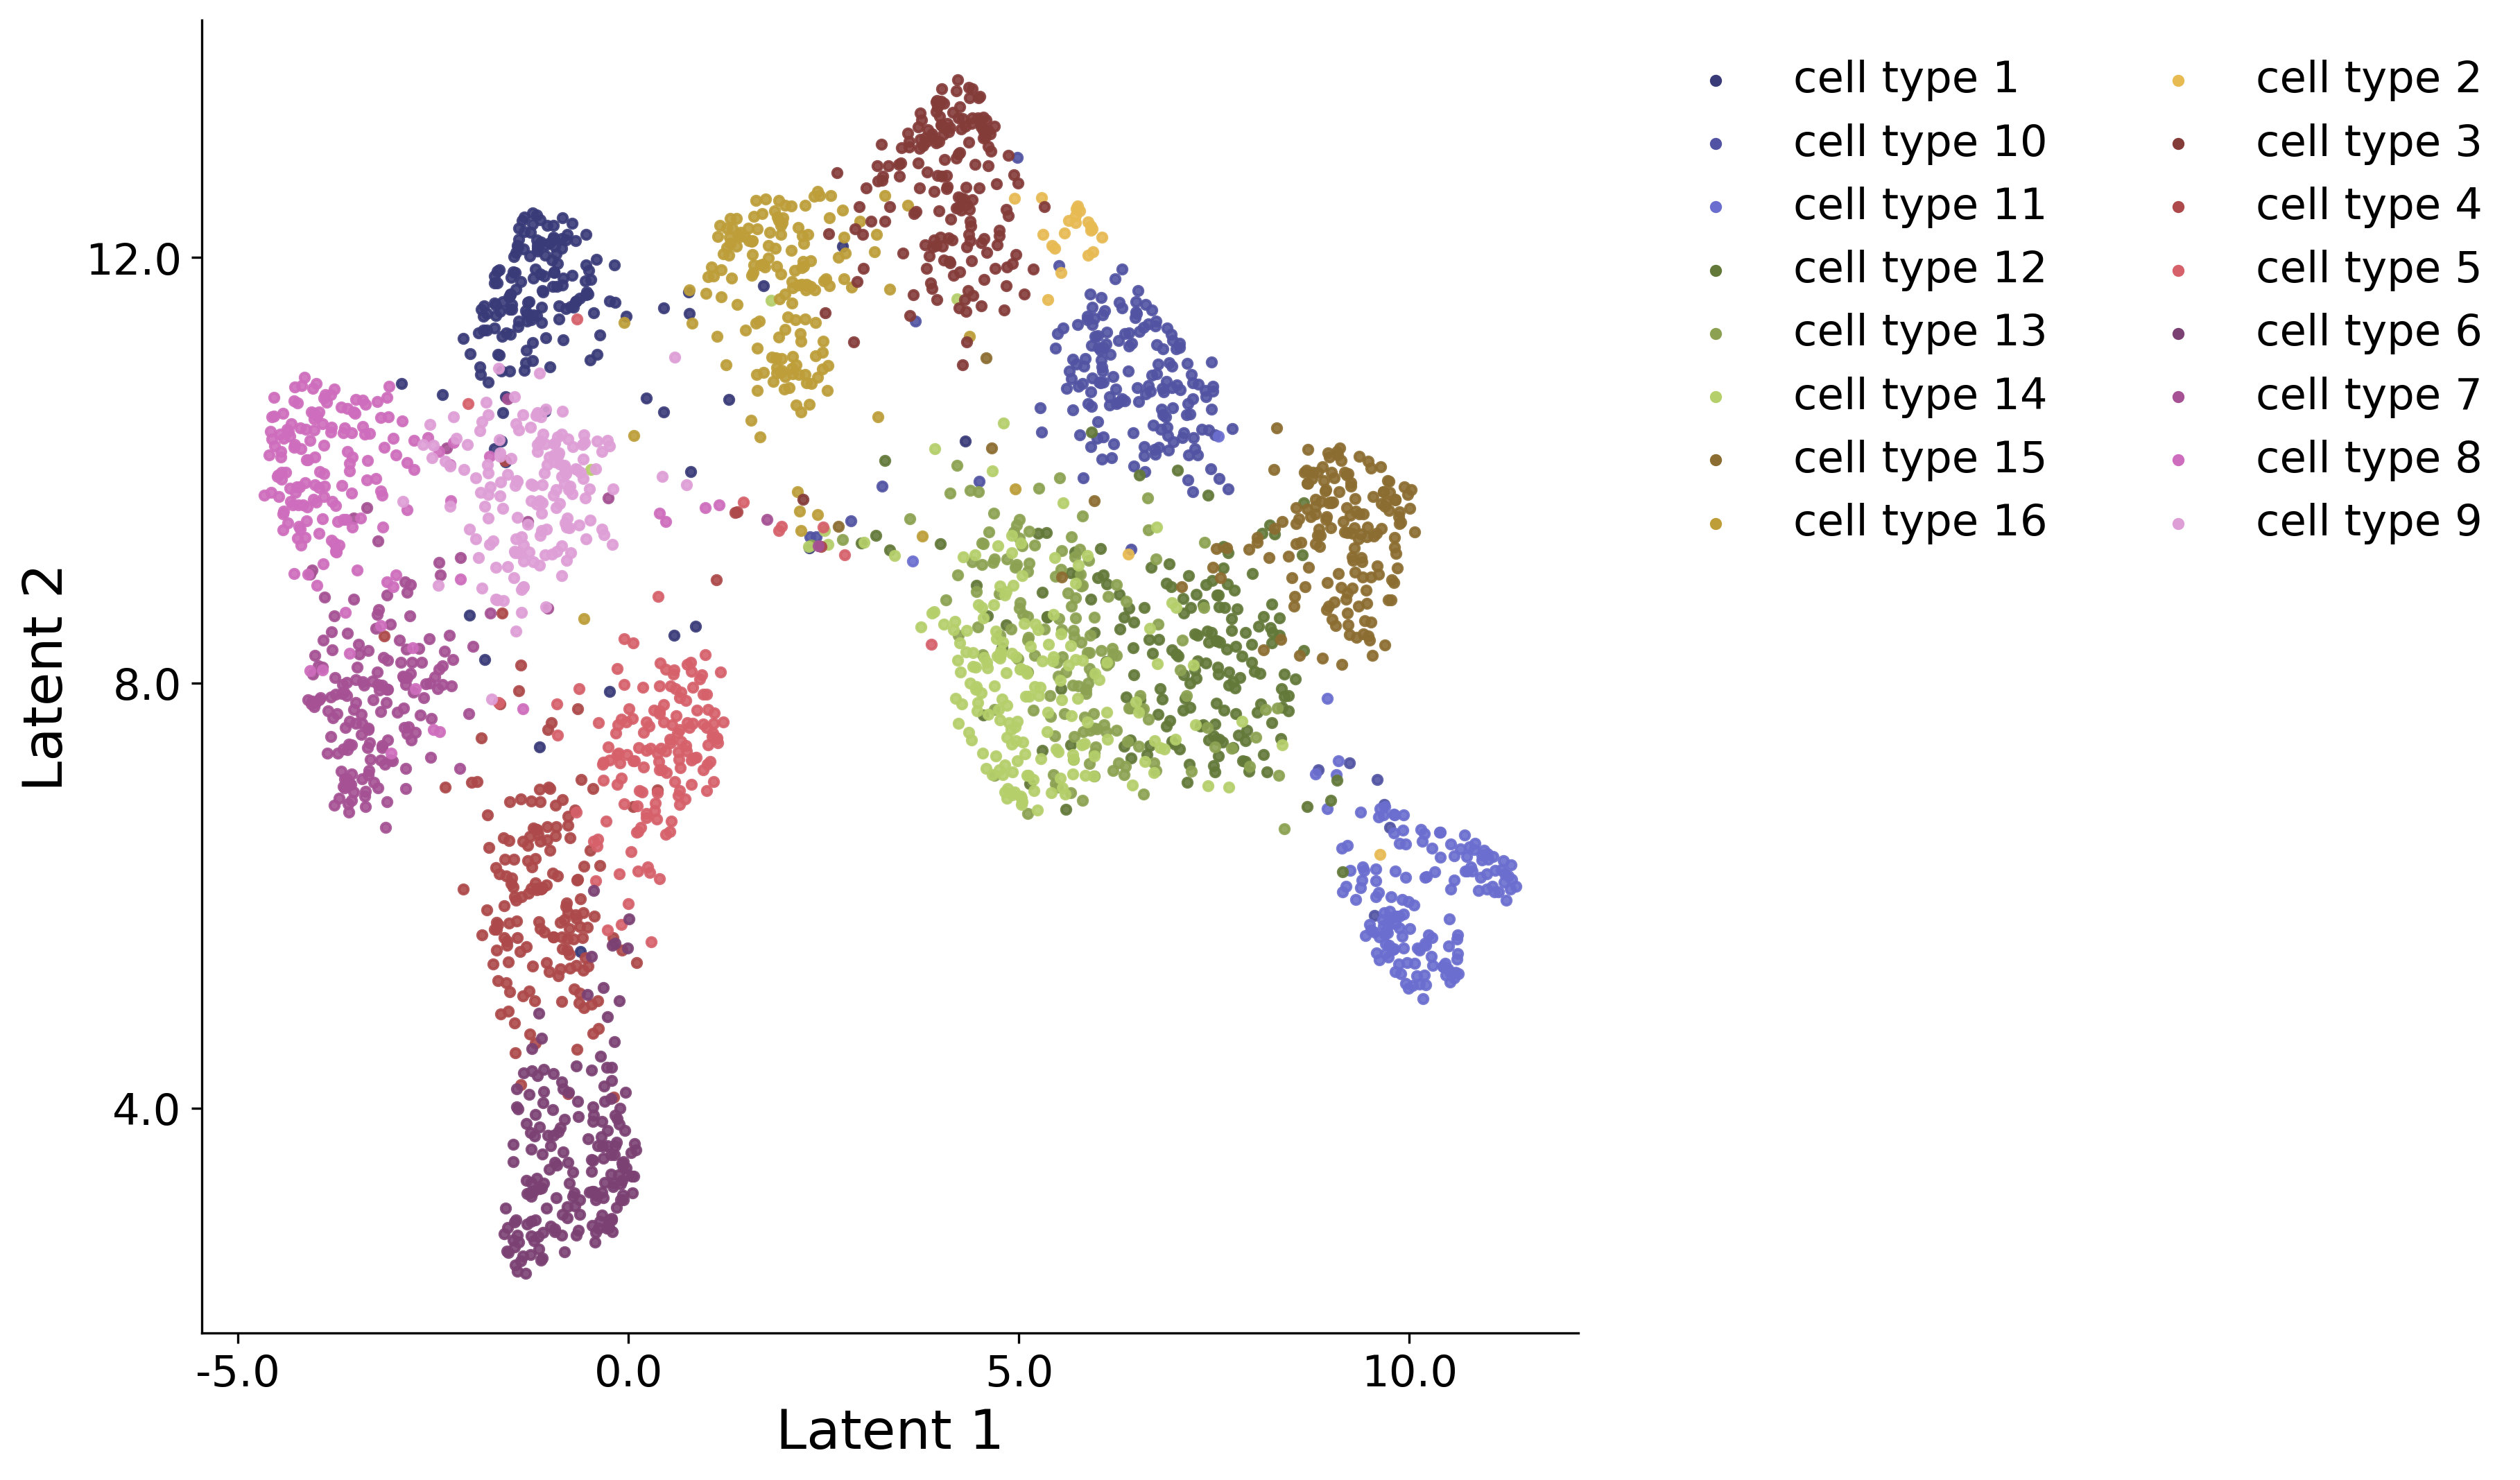

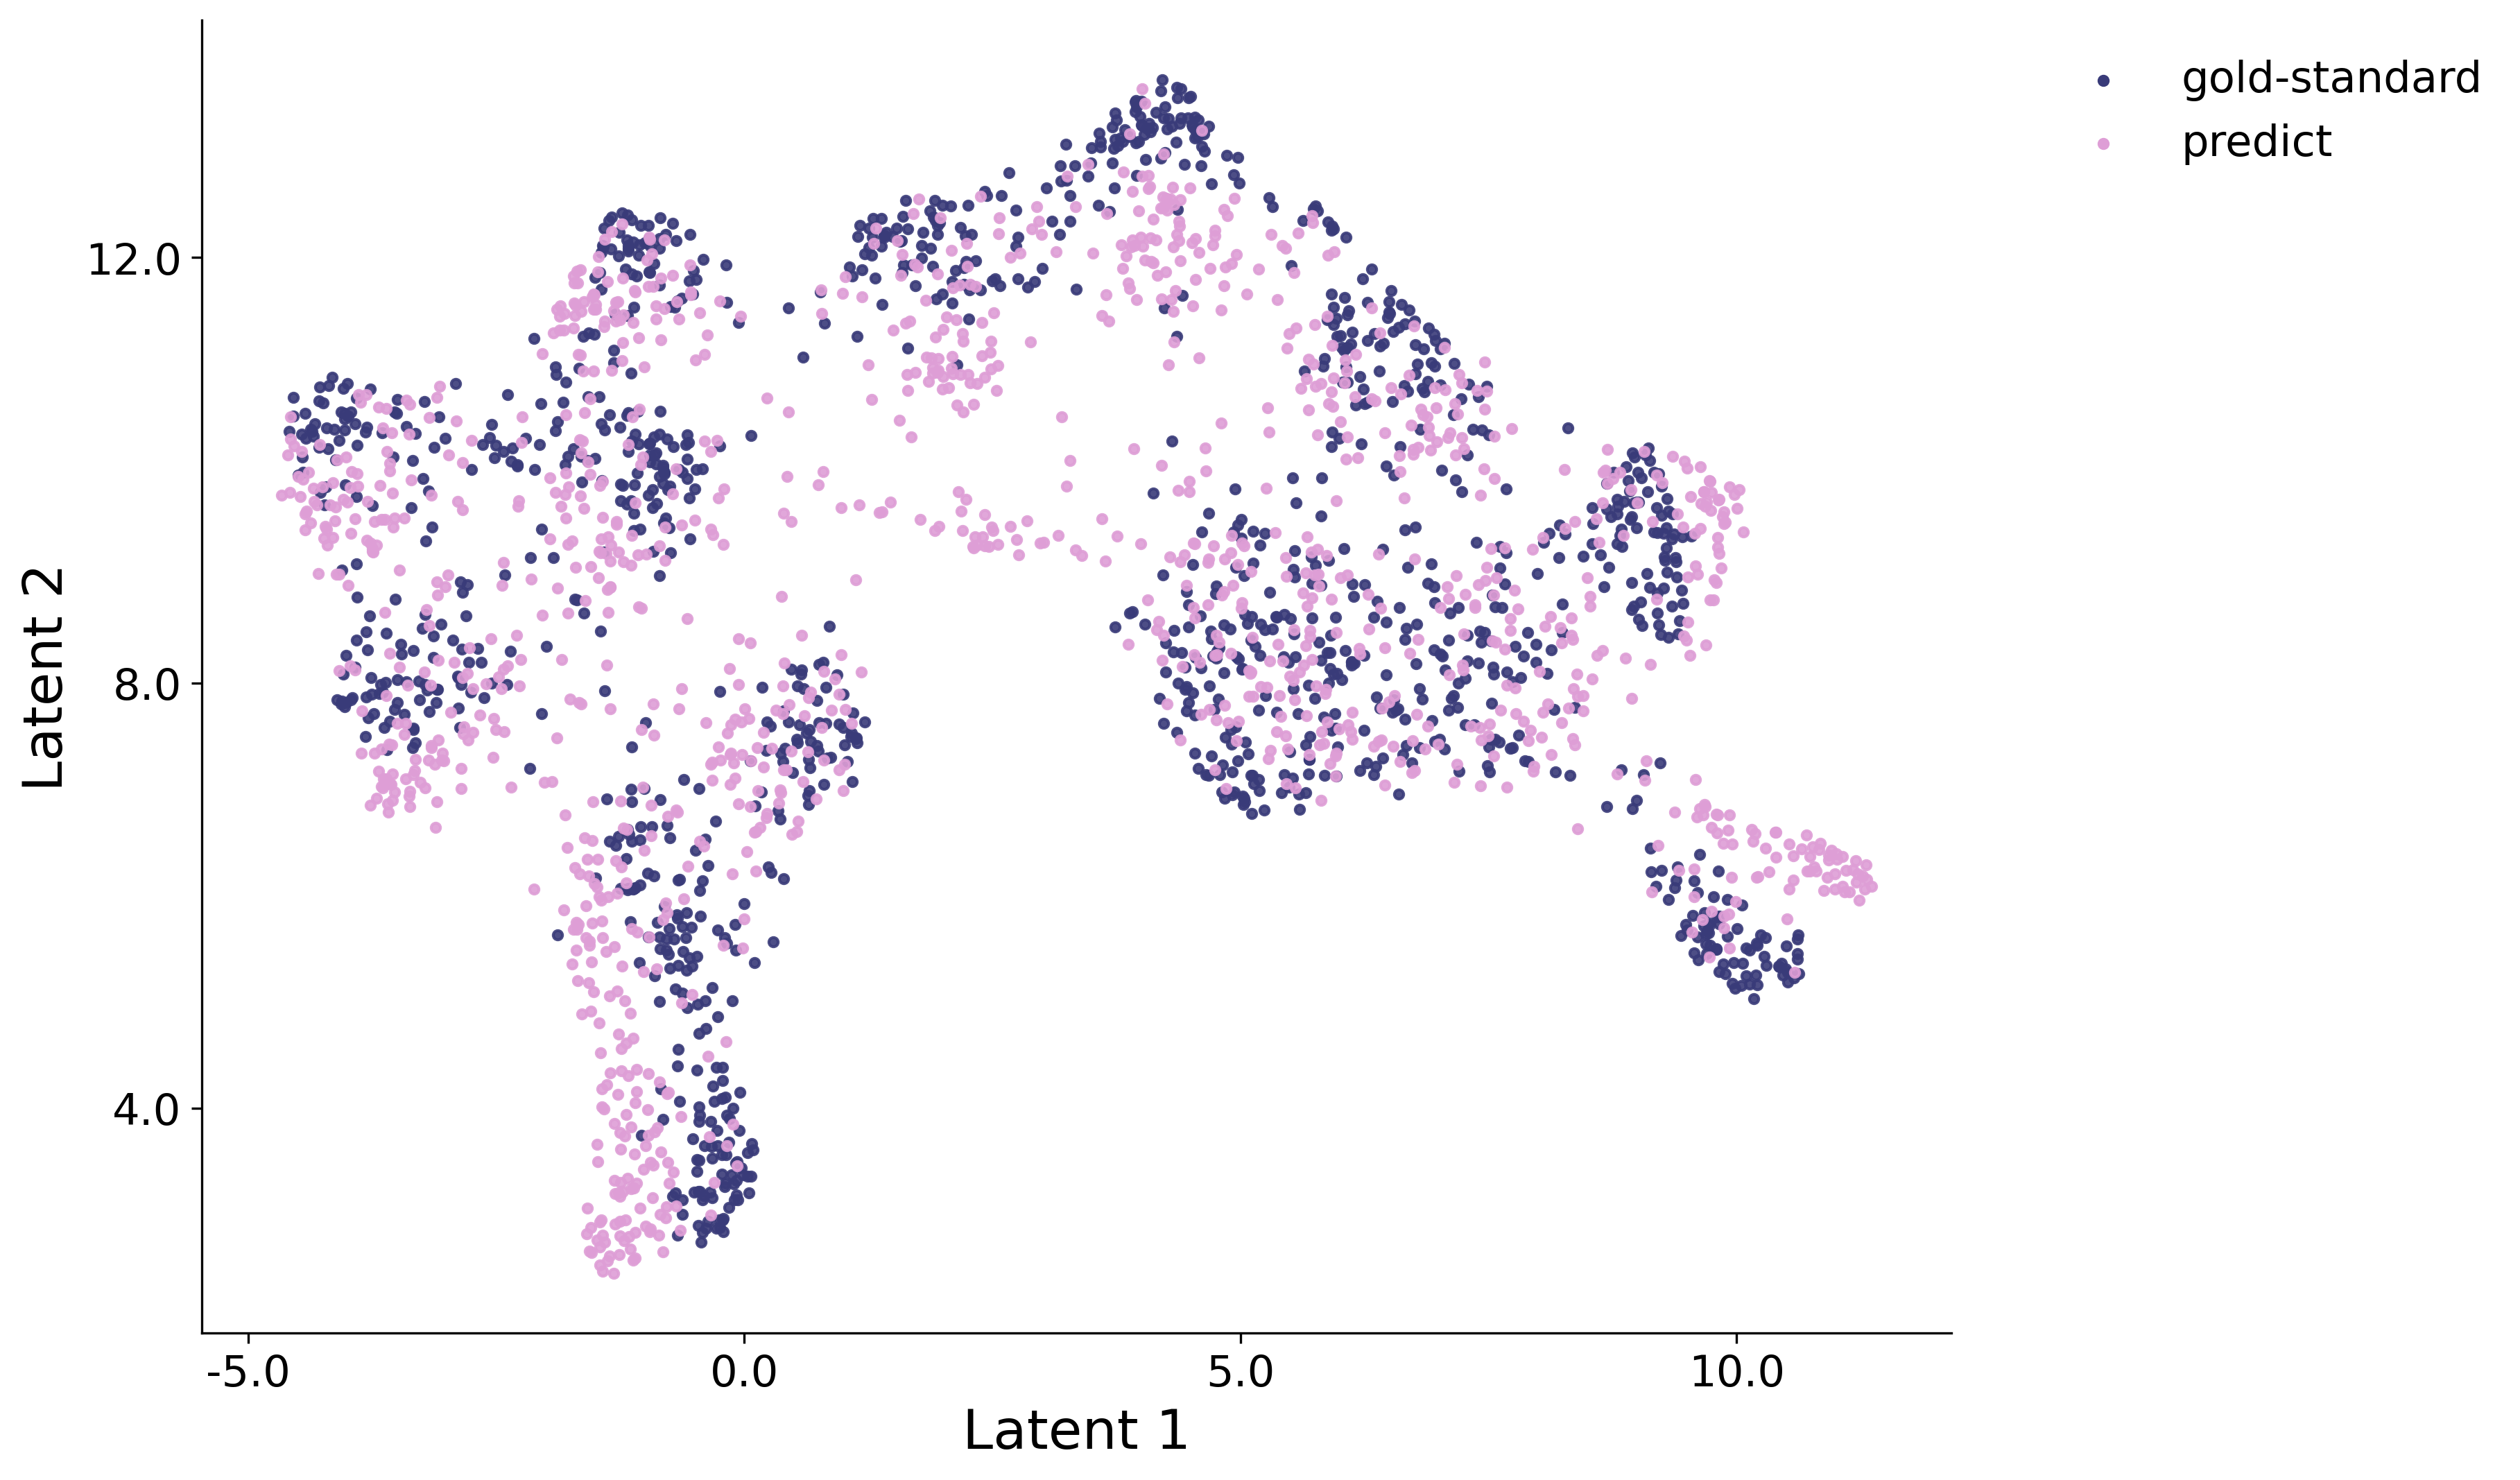

In [14]:
counts_predict_norm = counts_predict/(np.sum(counts_predict, axis = 1, keepdims = True) + 1e-6) * 100
counts_predict_norm = np.log1p(counts_predict_norm)
counts_test_norm = counts_test_denoised/(np.sum(counts_test_denoised, axis = 1, keepdims = True) + 1e-6) * 100
counts_test_norm = np.log1p(counts_test_norm)
# plot umap
umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0) 
x_umap_scdisinfact = umap_op.fit_transform(np.concatenate([counts_predict_norm, counts_test_norm], axis = 0))

utils.plot_latent(x_umap_scdisinfact, annos = np.concatenate([meta_input["annos"].values, meta_test["annos"].values], axis = 0), batches = np.array(["predict"] * counts_predict.shape[0] + ["gold-standard"] * counts_test.shape[0]), \
    mode = "annos", save = result_dir + comment + "predict_batches.png", figsize = (12,7))
utils.plot_latent(x_umap_scdisinfact, annos = np.concatenate([meta_input["annos"].values, meta_test["annos"].values], axis = 0), batches = np.array(["predict"] * counts_predict.shape[0] + ["gold-standard"] * counts_test.shape[0]), \
    mode = "batches", save = result_dir + comment + "predict_batches.png", figsize = (12,7))